### MLP-pitmodel

test the new feature 'cur_cautionlaps'

base: MLP-pitmodel-plen2

build a pitstop dataset with <cautions_laps, pitage, gap2nextpit>
gluonts interface of Dataset = Iterable[DataEntry], DataEntry = Dict(str, any)

+ input pitstop dataset, remove pitstops with pit_oncaution = 1, refer to lapstatus_dataset-fastrun
+ context_length = 1, prediction_length = 1
+ target : gap to nextpit
+ covariates are: cautions_laps, pitage, (carid, eid)
+ modeling the distribution of nextpit-gap


In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import random
import mxnet as mx
from mxnet import gluon
import pickle
import json
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import inspect
from scipy import stats
from pathlib import Path 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from gluonts.dataset.util import to_pandas
from pathlib import Path
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator, MultivariateEvaluator
from gluonts.model.predictor import Predictor
from gluonts.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.distribution.student_t import StudentTOutput
from gluonts.model.forecast import SampleForecast

from indycar.model.mlp import MLPEstimator

INFO:root:Using GPU


In [2]:
import os
os.getcwd()

'/scratch_hdd/hpda/indycar/notebook/22.PaperFinal'

In [3]:

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def test_flag(a, bitflag):
    return (a & bitflag) ==  bitflag

#
# remove NaN at the tail
# there should be no nans in the middle of the ts
COL_LAPTIME=0
COL_RANK=1
COL_TRACKSTATUS=2
COL_LAPSTATUS=3
COL_TIMEDIFF=4
COL_CAUTION_LAPS_INSTINT=5
COL_LAPS_INSTINT= 6
COL_ELAPSED_TIME= 7
COL_LAP2NEXTPIT = 8


MODE_ORACLE = 0
MODE_NOLAP = 1
MODE_NOTRACK = 2
MODE_TESTZERO = 4
MODE_TESTCURTRACK = 8
#MODE_STR={MODE_ORACLE:'oracle', MODE_NOLAP:'nolap',MODE_NOTRACK:'notrack',MODE_TEST:'test'}

def split_ts(rec, carno, eid, include_end = False):
    """
    input: 
        ts
    output:
        nextpit records
    """
    output = []
    pitstops = np.where(rec[COL_LAPSTATUS,:] == 1)[0]
    
    if len(pitstops)==0:
        print('no pit ts')
        return output
    
    #pit_oncaution = np.zeros_like((pitstops))
    #for pit in pitstops:
    #    if rec[COL_TRACKSTATUS,:] == 1:
    #        pit_oncaution = 1
    pit_oncaution = np.zeros_like((rec[COL_LAP2NEXTPIT,:]))
    stint_len = np.zeros_like((rec[COL_LAP2NEXTPIT,:]))
    pos = 0
    for pit in pitstops:
        if rec[COL_TRACKSTATUS,pit] == 1:
            #next pit is oncaution
            # set pos -> pit as oncaution
            pit_oncaution[pos:pit] = 1
        else:
            pit_oncaution[pos:pit] = 0
            
        stint_len[pos:pit] = pit - pos
        pos = pit
        
        
    # calc cur_cautionlaps
    # accumulate consecutive caution laps
    trackstatus = rec[COL_TRACKSTATUS,:]
    lapstatus = rec[COL_LAPSTATUS,:]
    
    #import pdb; pdb.set_trace()
    
    cur_cautionlaps = np.zeros_like(trackstatus)
    cautionlaps_acc = 0
    for idx in range(len(trackstatus)):
        if (trackstatus[idx] == 0) or (lapstatus[idx] == 1):
            #reset
            cautionlaps_acc = 0
        else:
            cautionlaps_acc += 1
            
        #save state
        cur_cautionlaps[idx] = cautionlaps_acc
        
            
    #prepare output : lap2nextpit, CAUTION_LAPS_INSTINT,LAPS_INSTINT, pit_oncaution, carno, eid, lap, stintlen
    if include_end:
        #rec = rec[:, ~np.isnan(rec[run_ts,:])]
        totallen = len(rec[COL_RANK, ~np.isnan(rec[COL_RANK,:])])
    else:
        totallen = pitstops[-1]
        
    # set the last stint target = 999, an invalid lap2nextpit
    for idx in range(totallen):
        output.append([ rec[COL_LAP2NEXTPIT ,idx] if idx < pitstops[-1] else 999
                        ,rec[COL_CAUTION_LAPS_INSTINT ,idx]
                        ,rec[COL_LAPS_INSTINT ,idx]
                        ,pit_oncaution[idx]
                        ,carno
                        ,eid
                        ,idx
                        ,stint_len[idx]
                        ,cur_cautionlaps[idx]
                      ])
        
    return output

def make_dataset_byevent(test_event = 'Indy500-2018', include_end = False):
    """
    split the ts to train and test part by the ratio
    
    oracle_mode: false to simulate prediction in real by 
        set the covariates of track and lap status as nan in the testset
            
    
    """    
    useeid = False
    run_ts = COL_LAP2NEXTPIT
    train_set = []
    test_set = []
    
    #_data: eventid, carids, datalist[carnumbers, features, lapnumber]->[laptime, rank, track, lap]]
    for _data in laptime_data:
        _train = []
        _test = []
        
        if events[_data[0]] == test_event:
            test_mode = True
        else:
            test_mode = False
            
        # process for each ts
        for rowid in range(_data[2].shape[0]):
            # rec[features, lapnumber] -> [laptime, rank, track_status, lap_status,timediff]]
            rec = _data[2][rowid].copy()
            
            #remove nan(only tails)
            nans, x= nan_helper(rec[run_ts,:])
            nan_count = np.sum(nans)             
            rec = rec[:, ~np.isnan(rec[run_ts,:])]
            
            # remove short ts
            totallen = rec.shape[1]
            
            carno = _data[1][rowid]
            carid = global_carids[_data[1][rowid]]
            
            eid = _data[0]
            
            # all go to train set
            output = split_ts(rec, carno, eid, include_end= include_end)
            #if len(output) == 0:
            #    continue
            
            test_rec_cnt = 0
            if not test_mode:
                _train.extend(output)
                
            else:
                _test.extend(output)
                test_rec_cnt += 1
            
            #add one ts
            print(f'carno:{carno}, totallen:{totallen}, nancount:{nan_count}, test_reccnt:{test_rec_cnt}')

        train_set.extend(_train)
        test_set.extend(_test)

    print(f'train len:{len(train_set)}, test len:{len(test_set)}')
    
    return train_set, test_set

def save_dataset(datafile,freq, prediction_length, cardinality, train_ds, test_ds):
    with open(datafile, 'wb') as f:
        #pack [global_carids, laptime_data]
        savedata = [freq, prediction_length, cardinality, train_ds, test_ds]
        #savedata = [freq, train_set, test_set]
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

In [4]:
#make gluonts
from sklearn.preprocessing import StandardScaler,MinMaxScaler

def makedb(data, scaler='standard', perm = True, feature_cnt=2):
    db = []
    start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series
    
    scalers = {'minmax':MinMaxScaler(), 'standard':StandardScaler()}
    
    if isinstance(scaler, str):
        if scaler in scalers:
            scaler = scalers[scaler]
            scaler.fit(data)
            df = scaler.transform(data)
        else:
            # no scaler
            df = data
    else:
        #use input scaler
        #scaler.fit(data)
        df = scaler.transform(data)
        
    
    #permute
    if perm:
        perm = np.random.permutation(len(df))
        df = df[perm]
    
    for x in df:
        if feature_cnt == 3:
            db.append({'target':np.array([x[0]]), 'feat':np.array([x[1],x[2],x[3]]),
                  "start":start, 'forecast_start':start})
        elif feature_cnt == 2:
            db.append({'target':np.array([x[0]]), 'feat':np.array([x[1],x[2]]),
                  "start":start, 'forecast_start':start})
        else:
            print('error _feature_cnt not support:', feature_cnt)
            break
        
    return db, scaler, df


def make_fulltestdb(scaler, maxgap=60, maxcautionlen=20, feature_cnt=2):
    db = []
    start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series

    data = []
    for caution_lap in range(maxgap):
        for pitage in range(caution_lap, maxgap):
            if feature_cnt == 2:        
                data.append([0.,caution_lap, pitage, 0])
            elif feature_cnt == 3:        
                for cur_cautionlap in range(0, caution_lap+1):
                    data.append([0.,caution_lap, pitage, cur_cautionlap])
    data = np.array(data)
    
    if not isinstance(scaler, str):
        df = scaler.transform(data)
    else:
        df = data
    
    #data
    print(f'make full testdb: {len(df)} records')
    for x in df:
        if feature_cnt == 3:        
            db.append({'target':np.array([x[0]]), 'feat':np.array([x[1],x[2],x[3]]),
                  "start":start, 'forecast_start':start})
        elif feature_cnt == 2:
            db.append({'target':np.array([x[0]]), 'feat':np.array([x[1],x[2]]),
                  "start":start, 'forecast_start':start})
        else:
            print('error _feature_cnt not support:', feature_cnt)
            break

    #reset data, used by PitModel.save_model()
    if feature_cnt == 2:
        data = data[:,:3]            
            
    return db, scaler, df, data

In [5]:
def train_model(epochs, layers=[10,10,5], output = 'student', dropout = .5, id='all'):
    distr_outputs ={'student':StudentTOutput(),  
                    'negbin':NegativeBinomialOutput() 
                   }
    if not output in distr_outputs:
        print(f'distr_output: {output} not found error.')
        return
    
    distr_output = distr_outputs[output]
    
    modelid = 'mlp-d%s-e%s-l%s-%s-d%s'%(id, epochs, '-'.join([str(x) for x in layers]), output, dropout)
    
    estimator = MLPEstimator(
        num_hidden_dimensions=layers,
        prediction_length=1,
        context_length=1,
        freq='1min',
        dropout = dropout,
        distr_output = distr_output,
        trainer=Trainer(ctx="gpu(0)", 
                        batch_size = 32,
                        epochs= epochs,
                        learning_rate=1e-3,
                        hybridize=False,
                        num_batches_per_epoch=100
                       )
    )    

    predictor = estimator.train(train_ds)

    return predictor, modelid

def eval_model(predictor, test_ds):
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset    
        predictor=predictor,  # predictor                                  
        num_samples=1000,  # number of sample paths we want for evaluation 
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)     
    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9]) 
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    print(json.dumps(agg_metrics, indent=4)) 
    return tss, forecasts, agg_metrics


def raw_eval(tss, forecasts):
    """
    scaler
    """
    #rec = np.zeros((_feature_cnt + 1))
    rec = np.zeros((4))

    truth, pred = [],[]
    #go through the dataset
    for idx in range(len(tss)):
        rec[0] = list(tss[idx].values)[0]
    
        if isinstance(scaler, str):
            truth.append(int(rec[0]))
        else:
            truth.append(int(scaler.inverse_transform(rec)[0]))
    
        rec[0] = np.mean(forecasts[idx].samples)
        
        if isinstance(scaler, str):
            pred.append(int(rec[0]))    
        else:
            pred.append(int(scaler.inverse_transform(rec)[0]))        

    #get mae
    mae = mean_absolute_error(truth, pred)
    print('mae = ', mae)
    return mae

def decode(tss, forecasts):
    """
    scaler
    """
    #rec = np.zeros((_feature_cnt + 1))
    rec = np.zeros((4))

    truth, pred = [],[]
    sampleCnt = forecasts[0].samples.shape[0]
    samples = np.zeros((sampleCnt, len(tss)))
    
    #go through the dataset
    for idx in range(len(tss)):
        rec[0] = list(tss[idx].values)[0]
    
        if isinstance(scaler, str):
            truth.append(int(rec[0]))
        else:
            truth.append(int(scaler.inverse_transform(rec)[0]))
    
        #pred
        rec[0] = np.mean(forecasts[idx].samples)
        
        if isinstance(scaler, str):
            pred.append(int(rec[0]))    
        else:
            pred.append(int(scaler.inverse_transform(rec)[0]))        
            
        #samples
        for sid in range(sampleCnt):
            rec[0] = forecasts[idx].samples[sid]
            if isinstance(scaler, str):
                pred.append(int(rec[0]))    
                samples[sid, idx] = int(rec[0])
            else:
                samples[sid, idx] = int(scaler.inverse_transform(rec)[0])        
    
    return truth, pred, samples

def save_model(predictor, outdir):
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    
    predictor.serialize(Path(outdir)) 


In [6]:
### pitmodel
class PitModel():
    """
     <caution_lap, pitage> -> [distribution]    
     distribution := sorted cdf [val:probability, val2:p2, ...]
         [0,:] -> val
         [1,:] -> cdf p
         
     no scaler, raw feat and target
    
    """
    def __init__(self, modelfile=''):
        self.model = {}
        self.name = ''
        
        if modelfile:
            self.load_model(modelfile)
                
    def load_model(self, modelfile):
        with open(modelfile, 'rb') as f:
            self.name, self.model = pickle.load(f, encoding='latin1')
            print(f'init model:{self.name}')
        
    def save_model(self, modelname, test_ds, forecasts, scaler):
        
        model = {}
        
        #get the sclaer for the first column(lap2nextpit)
        sc, scf = '', ''
        if isinstance(scaler, StandardScaler):
            sc = StandardScaler()
            sc.scale_ = scaler.scale_[0]
            sc.mean_ = scaler.mean_[0]
            sc.var_ = scaler.var_[0]

            scf = StandardScaler()
            scf.scale_ = scaler.scale_[1:]
            scf.mean_ = scaler.mean_[1:]
            scf.var_ = scaler.var_[1:]

        
        for idx, rec in enumerate(test_ds):
            feat = rec[1:]
                
            key = '-'.join([str(int(x)) for x in feat])
            
            if not key in model:
            
                samples = forecasts[idx].samples.reshape(-1)
                
                if not isinstance(sc, str):
                    samples = sc.inverse_transform(samples)
                
                #force to prediction to be valid lap2nextpit
                samples = samples.astype(int)
                samples = samples[samples > 0]

                #
                valset = set(list(samples))
                plen = len(valset)
                distr = np.zeros((2, plen))
                distr[0, :] = sorted(valset)
                smap = {val:id for id, val in enumerate(distr[0, :])}
                for s in samples:
                    distr[1,smap[s]] += 1
                tsum = np.sum(distr[1,:])
                distr[1, :] /= tsum
                distr[1, :] = np.cumsum(distr[1, :])

                model[key] = distr
                
        #save model
        self.model = model
        self.name = modelname
        with open(modelname, 'wb') as f:
            savedata = [self.name, self.model]
            pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)        
        print(f'save model {modelname} with {len(self.model)} keys.')
                
    def predict(self, *args):
        key = '-'.join([str(int(x)) for x in args])
        #if key in self.model:
        try:
            distr = self.model[key]
            
            #[0, 1.)
            p = np.random.random()  
            i = np.sum(distr[1,:] < p)
            
            return distr[0,i]
        except:
            #exception
            #todo, backto special model
            print(f'ERROR: key {key} not found in model')
                       
    def forecast_ds(self, test_ds, forecasts):
        """
        test_ds as testset, the unsclaed input
        forecasts ; the template
        """
        
        plen = len(test_ds)
        sample_cnt = forecasts[0].samples.shape[0]
        assert(plen == len(forecasts))
        

        #build a new forecasts object
        nf = []
        for fc in forecasts:
            nfc = SampleForecast(samples = np.zeros_like(fc.samples), 
                                 freq=fc.freq, start_date=fc.start_date)
            nf.append(nfc)
        
        for idx, rec in enumerate(test_ds):
            feat = rec[1:]
                    
            onecast = np.zeros((sample_cnt))
            for i in range(sample_cnt):
                #onecast[i] = self.predict(feat[0], feat[1],feat[2])
                onecast[i] = self.predict(*feat)
        
            nf[idx].samples = onecast

        return nf
    
    def forecast_onecar(self, test_ds, plen = 2, sample_cnt=100):
        """
        long-prediction for a single car
        
        input:
            test_df ; 'lap2nextpit','caution_laps','pitage','lap'
        """
        
        #assert for one car
        totallen = len(test_ds)
        start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series
        
        #samples
        #onecast = np.zeros((sample_cnt, totallen+plen))
        onecast = np.zeros((sample_cnt, totallen))
        #onecast = np.zeros((sample_cnt, maxlap))
        tss = np.zeros((totallen+plen))
        
        for idx, rec in enumerate(test_ds[:-plen]):
        #for idx in range(maxlap-plen):
            
            #if idx<len(test_ds):
            #    rec = test_ds[idx]
            #else:
            #    #use the last rec
            #    # target, cautionlaps, pitage, cur_curcautionlaps
            #    rec = [0, ] 
                
            target = rec[0]
            feat = rec[1:]
            
            if target == plen:
                tss[idx + plen] = 1
            
            for i in range(sample_cnt):
                nextpit = self.predict(*feat)
                                                    
                if nextpit == plen:
                    onecast[i, idx + plen] = 1
                
        forecast = SampleForecast(samples = onecast, 
                             freq='1min', start_date=start)

        return forecast, tss
    
    
def save_full_pitmodel(mid, runid, maxgap=60):
    """
    input:
        p[mid]; predictor
        runid ; 'all' or 'sel' of the trainning set
    """
    
    #get scaler
    scaler = _data[runid][-1]

    # make full test set
    test_ds, _, _, test_all = make_fulltestdb(scaler, maxgap = maxgap)

    tss,forecasts, _ = eval_model(p[mid], test_ds)

    pitmodel = PitModel()

    #pitmodel.save_model(f'pitmodel-m{maxgap}-{mid}.pickle', test_all, forecasts, scaler)
    pitmodel.save_model(f'pitmodel-m{maxgap}-{mid}-1k-{featurecnt_str}.pickle', test_all, forecasts, scaler)

    return pitmodel

### create dbs

In [7]:
def build_datasets(test_event, include_end, feature_cnt=2):
    
    _data = {}
    
    train, test =  make_dataset_byevent(test_event = test_event, include_end = include_end)
    #prepare output : lap2nextpit, CAUTION_LAPS_INSTINT,LAPS_INSTINT, pit_oncaution, carno, eid, lap
    df_train = pd.DataFrame(train,columns=['lap2nextpit', 'caution_laps','pitage', 'pit_oncaution', 
                     'carno','eid','lap','stint_len','cur_cautionlaps'])
    df_test = pd.DataFrame(test,columns=['lap2nextpit', 'caution_laps','pitage', 'pit_oncaution', 
                     'carno','eid','lap','stint_len','cur_cautionlaps'])
    
    train_sel = df_train[(df_train['pit_oncaution']==0) &(df_train['stint_len']>23)]

    train_sel_2013_2017 = train_sel[train_sel['eid']<5]
    train_all_2013_2017 = df_train[df_train['eid']<5]

    print(len(train_all_2013_2017), len(train_sel_2013_2017))    

    test_sel = df_test[(df_test['pit_oncaution']==0) &(df_test['stint_len']>23)]
    test_all = df_test

    train_sel_noshort = df_train[(df_train['stint_len']>15)]
    train_sel_noshort_2013_2017 = train_sel_noshort[train_sel_noshort['eid']<5]
    test_sel_noshort = df_test[(df_test['stint_len']>15)]    
    
    
    # selected db
    trainset = train_sel_2013_2017[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    testset = test_sel[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    train_ds, scaler, _ = makedb(trainset, scaler='standard',feature_cnt=feature_cnt)
    test_ds, _, _ = makedb(testset, scaler, perm=False,feature_cnt=feature_cnt)

    _data['sel'] = [trainset, testset, train_ds, test_ds, scaler]


    # selected db
    trainset = train_all_2013_2017[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    testset = test_all[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    train_ds, scaler, _ = makedb(trainset, scaler='standard',feature_cnt=feature_cnt)
    test_ds, _, _ = makedb(testset, scaler, perm=False,feature_cnt=feature_cnt)

    _data['all'] = [trainset, testset, train_ds, test_ds, scaler]


    # selected db
    trainset = train_sel_noshort_2013_2017[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    testset = test_sel_noshort[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    train_ds, scaler, _ = makedb(trainset, scaler='standard',feature_cnt=feature_cnt)
    test_ds, _, _ = makedb(testset, scaler, perm=False,feature_cnt=feature_cnt)

    _data['noshort'] = [trainset, testset, train_ds, test_ds, scaler]    

    # add normal (normal pit only, with short pits)

    train_sel_normal = df_train[(df_train['pit_oncaution']==0)]

    train_sel_normal_2013_2017 = train_sel_normal[train_sel_normal['eid']<5]
    test_sel_normal = df_test[(df_test['pit_oncaution']==0)]


    trainset = train_sel_normal_2013_2017[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    testset = test_sel_normal[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values

    train_ds, scaler, _ = makedb(trainset, scaler='standard',feature_cnt=feature_cnt)
    test_ds, _, _ = makedb(testset, scaler, perm=False,feature_cnt=feature_cnt)

    _data['normal'] = [trainset, testset, train_ds, test_ds, scaler]
    
    return df_train, df_test, _data

In [8]:
_inlap_status = 0
#years = ['2013','2014','2015','2016','2017','2018','2019']
years = ['2013','2014','2015','2016','2017','2018','2019']
#events = ['Indy500']
events = [f'Indy500-{x}' for x in years]
events_id={key:idx for idx, key in enumerate(events)}
dbid = f'Indy500_{years[0]}_{years[-1]}_v9_p{_inlap_status}'

# start from here
import pickle
#with open('laptime_rank_timediff_fulltest-oracle-%s.pickle'%year, 'rb') as f:
with open(f'laptime_rank_timediff_pit-oracle-{dbid}.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    global_carids, laptime_data = pickle.load(f, encoding='latin1') 

In [9]:
include_end = True
includeend_str = '-includeend' if include_end else ''

In [10]:
#model store
dataset = {}

In [11]:
testevents = ['Indy500-2018','Indy500-2019']

for testevent in testevents:
    for feature_cnt in [2,3]:
        df_train, df_test, _data= build_datasets(testevent, include_end, feature_cnt=feature_cnt)

        dataset[testevent] = [df_train, df_test, _data]
        featurecnt_str = 'withcurcautionlaps' if (feature_cnt==3) else 'nocurcautionlaps'

        datafile = f'pitstop_nextpit_dataset-{dbid}-t{testevent}-alldata-{featurecnt_str}{includeend_str}.pickle'
        with open(datafile, 'wb') as f:
            print('save data:', datafile)
            savedata = [df_train, df_test, events, testevent, _data]
            pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

carno:1, totallen:200, nancount:0, test_reccnt:0
carno:2, totallen:200, nancount:0, test_reccnt:0
carno:3, totallen:200, nancount:0, test_reccnt:0
no pit ts
carno:4, totallen:0, nancount:200, test_reccnt:0
carno:5, totallen:200, nancount:0, test_reccnt:0
no pit ts
carno:6, totallen:30, nancount:170, test_reccnt:0
carno:7, totallen:177, nancount:23, test_reccnt:0
carno:8, totallen:200, nancount:0, test_reccnt:0
carno:9, totallen:200, nancount:0, test_reccnt:0
carno:10, totallen:187, nancount:13, test_reccnt:0
carno:11, totallen:200, nancount:0, test_reccnt:0
carno:12, totallen:200, nancount:0, test_reccnt:0
carno:14, totallen:200, nancount:0, test_reccnt:0
carno:15, totallen:170, nancount:30, test_reccnt:0
carno:16, totallen:179, nancount:21, test_reccnt:0
carno:18, totallen:200, nancount:0, test_reccnt:0
carno:19, totallen:200, nancount:0, test_reccnt:0
carno:20, totallen:200, nancount:0, test_reccnt:0
carno:21, totallen:170, nancount:30, test_reccnt:0
carno:22, totallen:200, nancount:

save data: pitstop_nextpit_dataset-Indy500_2013_2019_v9_p0-tIndy500-2018-alldata-nocurcautionlaps-includeend.pickle
carno:1, totallen:200, nancount:0, test_reccnt:0
carno:2, totallen:200, nancount:0, test_reccnt:0
carno:3, totallen:200, nancount:0, test_reccnt:0
no pit ts
carno:4, totallen:0, nancount:200, test_reccnt:0
carno:5, totallen:200, nancount:0, test_reccnt:0
no pit ts
carno:6, totallen:30, nancount:170, test_reccnt:0
carno:7, totallen:177, nancount:23, test_reccnt:0
carno:8, totallen:200, nancount:0, test_reccnt:0
carno:9, totallen:200, nancount:0, test_reccnt:0
carno:10, totallen:187, nancount:13, test_reccnt:0
carno:11, totallen:200, nancount:0, test_reccnt:0
carno:12, totallen:200, nancount:0, test_reccnt:0
carno:14, totallen:200, nancount:0, test_reccnt:0
carno:15, totallen:170, nancount:30, test_reccnt:0
carno:16, totallen:179, nancount:21, test_reccnt:0
carno:18, totallen:200, nancount:0, test_reccnt:0
carno:19, totallen:200, nancount:0, test_reccnt:0
carno:20, totallen

save data: pitstop_nextpit_dataset-Indy500_2013_2019_v9_p0-tIndy500-2018-alldata-withcurcautionlaps-includeend.pickle
carno:1, totallen:200, nancount:0, test_reccnt:0
carno:2, totallen:200, nancount:0, test_reccnt:0
carno:3, totallen:200, nancount:0, test_reccnt:0
no pit ts
carno:4, totallen:0, nancount:200, test_reccnt:0
carno:5, totallen:200, nancount:0, test_reccnt:0
no pit ts
carno:6, totallen:30, nancount:170, test_reccnt:0
carno:7, totallen:177, nancount:23, test_reccnt:0
carno:8, totallen:200, nancount:0, test_reccnt:0
carno:9, totallen:200, nancount:0, test_reccnt:0
carno:10, totallen:187, nancount:13, test_reccnt:0
carno:11, totallen:200, nancount:0, test_reccnt:0
carno:12, totallen:200, nancount:0, test_reccnt:0
carno:14, totallen:200, nancount:0, test_reccnt:0
carno:15, totallen:170, nancount:30, test_reccnt:0
carno:16, totallen:179, nancount:21, test_reccnt:0
carno:18, totallen:200, nancount:0, test_reccnt:0
carno:19, totallen:200, nancount:0, test_reccnt:0
carno:20, totall

save data: pitstop_nextpit_dataset-Indy500_2013_2019_v9_p0-tIndy500-2019-alldata-nocurcautionlaps-includeend.pickle
carno:1, totallen:200, nancount:0, test_reccnt:0
carno:2, totallen:200, nancount:0, test_reccnt:0
carno:3, totallen:200, nancount:0, test_reccnt:0
no pit ts
carno:4, totallen:0, nancount:200, test_reccnt:0
carno:5, totallen:200, nancount:0, test_reccnt:0
no pit ts
carno:6, totallen:30, nancount:170, test_reccnt:0
carno:7, totallen:177, nancount:23, test_reccnt:0
carno:8, totallen:200, nancount:0, test_reccnt:0
carno:9, totallen:200, nancount:0, test_reccnt:0
carno:10, totallen:187, nancount:13, test_reccnt:0
carno:11, totallen:200, nancount:0, test_reccnt:0
carno:12, totallen:200, nancount:0, test_reccnt:0
carno:14, totallen:200, nancount:0, test_reccnt:0
carno:15, totallen:170, nancount:30, test_reccnt:0
carno:16, totallen:179, nancount:21, test_reccnt:0
carno:18, totallen:200, nancount:0, test_reccnt:0
carno:19, totallen:200, nancount:0, test_reccnt:0
carno:20, totallen

save data: pitstop_nextpit_dataset-Indy500_2013_2019_v9_p0-tIndy500-2019-alldata-withcurcautionlaps-includeend.pickle


### train the models

In [101]:
p, t, s, e = {}, {} ,{}, {}

In [102]:
#sync_test_ds = _data['all'][3]
sync_testset = _data['normal'][1]

cols = ['Year','Model','MAE','50-Risk','90-Risk']

### run train on all data
allruns = ['sel','all','noshort','normal']
year='2018'

retdata = []
for tid in allruns:
    trainset, testset, train_ds, test_ds, scaler = _data[tid]

    sync_test_ds, _, _ = makedb(sync_testset, scaler, perm=False)
    
    pm, mid = train_model(500,dropout = 0.1,id=tid)
    t[mid],s[mid], e[mid] = eval_model(pm, sync_test_ds)
    p[mid] = pm

    mae = raw_eval(t[mid],s[mid])
    retdata.append([year,tid, mae, e[mid]["wQuantileLoss[0.5]"],e[mid]["wQuantileLoss[0.9]"]])

    #run_test(t[mid], s[mid], [31,816,846,856])
    pitmodel = save_full_pitmodel(mid, tid, maxgap=65)
    
pitmodel_result = pd.DataFrame(data=retdata, columns=cols)

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 156.54it/s, avg_epoch_loss=1.35]
INFO:root:Epoch[0] Elapsed time 0.641 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.345233
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 167.10it/s, avg_epoch_loss=0.833]
INFO:root:Epoch[1] Elapsed time 0.600 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.833070
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 164.24it/s, avg_epoch_loss=0.553]
INFO:root:Epoch[2] Elapsed time 0.611 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.553042
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 147.94it/s, avg_epoch_loss=0.383]
INFO:root:Epoch[3] Elapsed time 0.678 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.383148
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 165.01it/

100%|██████████| 100/100 [00:00<00:00, 169.50it/s, avg_epoch_loss=0.0441]
INFO:root:Epoch[72] Elapsed time 0.592 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=0.044145
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 166.44it/s, avg_epoch_loss=0.0483]
INFO:root:Epoch[73] Elapsed time 0.603 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.048290
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 162.41it/s, avg_epoch_loss=0.0625]
INFO:root:Epoch[74] Elapsed time 0.617 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.062499
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 171.07it/s, avg_epoch_loss=0.0478]
INFO:root:Epoch[75] Elapsed time 0.586 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.047820
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 174.75it/s, avg_epoch_loss=0.0635]
INFO:root:Epoch[76] El

INFO:root:Epoch[107] Evaluation metric 'epoch_loss'=0.083599
INFO:root:Epoch[108] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.37it/s, avg_epoch_loss=0.0581]
INFO:root:Epoch[108] Elapsed time 0.596 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=0.058091
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.07it/s, avg_epoch_loss=0.0654]
INFO:root:Epoch[109] Elapsed time 0.586 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.065418
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.81it/s, avg_epoch_loss=0.0607]
INFO:root:Epoch[110] Elapsed time 0.612 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.060736
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 146.47it/s, avg_epoch_loss=0.0861]
INFO:root:Epoch[111] Elapsed time 0.684 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.086103
INFO:root:Epoch[112] Learning r

INFO:root:Epoch[144] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.46it/s, avg_epoch_loss=0.0311]
INFO:root:Epoch[144] Elapsed time 0.592 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=0.031115
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.67it/s, avg_epoch_loss=0.079]
INFO:root:Epoch[145] Elapsed time 0.624 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.079005
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.07it/s, avg_epoch_loss=0.0562]
INFO:root:Epoch[146] Elapsed time 0.590 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.056200
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.08it/s, avg_epoch_loss=0.0339]
INFO:root:Epoch[147] Elapsed time 0.586 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.033932
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.06it/s

100%|██████████| 100/100 [00:00<00:00, 154.25it/s, avg_epoch_loss=0.0659]
INFO:root:Epoch[180] Elapsed time 0.650 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=0.065917
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.50it/s, avg_epoch_loss=0.0402]
INFO:root:Epoch[181] Elapsed time 0.610 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.040175
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.25it/s, avg_epoch_loss=0.0292]
INFO:root:Epoch[182] Elapsed time 0.659 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=0.029170
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.77it/s, avg_epoch_loss=0.0321]
INFO:root:Epoch[183] Elapsed time 0.567 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.032094
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.38it/s, avg_epoch_loss=0.0495]
INFO:root:Epoch[18

100%|██████████| 100/100 [00:00<00:00, 174.70it/s, avg_epoch_loss=0.0446]
INFO:root:Epoch[252] Elapsed time 0.574 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=0.044610
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 153.94it/s, avg_epoch_loss=0.0418]
INFO:root:Epoch[253] Elapsed time 0.651 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=0.041794
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.59it/s, avg_epoch_loss=0.0405]
INFO:root:Epoch[254] Elapsed time 0.598 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=0.040487
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.47it/s, avg_epoch_loss=0.0559]
INFO:root:Epoch[255] Elapsed time 0.581 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=0.055901
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.25it/s, avg_epoch_loss=0.0568]
INFO:root:Epoch[25

100%|██████████| 100/100 [00:00<00:00, 156.17it/s, avg_epoch_loss=0.0441]
INFO:root:Epoch[324] Elapsed time 0.642 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=0.044089
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.70it/s, avg_epoch_loss=0.0706]
INFO:root:Epoch[325] Elapsed time 0.591 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.070584
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.53it/s, avg_epoch_loss=0.0481]
INFO:root:Epoch[326] Elapsed time 0.598 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.048131
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.59it/s, avg_epoch_loss=0.0457]
INFO:root:Epoch[327] Elapsed time 0.595 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=0.045743
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.05it/s, avg_epoch_loss=0.0565]
INFO:root:Epoch[32

100%|██████████| 100/100 [00:00<00:00, 168.45it/s, avg_epoch_loss=0.00579]
INFO:root:Epoch[396] Elapsed time 0.595 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=0.005794
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.27it/s, avg_epoch_loss=0.0305]
INFO:root:Epoch[397] Elapsed time 0.596 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=0.030550
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.76it/s, avg_epoch_loss=0.0334]
INFO:root:Epoch[398] Elapsed time 0.601 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=0.033357
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.71it/s, avg_epoch_loss=0.0751]
INFO:root:Epoch[399] Elapsed time 0.587 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=0.075090
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.20it/s, avg_epoch_loss=0.0337]
INFO:root:Epoch[4

100%|██████████| 100/100 [00:00<00:00, 180.86it/s, avg_epoch_loss=0.0271]
INFO:root:Epoch[468] Elapsed time 0.555 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=0.027051
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.43it/s, avg_epoch_loss=0.0362]
INFO:root:Epoch[469] Elapsed time 0.562 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=0.036180
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.29it/s, avg_epoch_loss=0.0421]
INFO:root:Epoch[470] Elapsed time 0.553 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=0.042116
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.22it/s, avg_epoch_loss=0.0422]
INFO:root:Epoch[471] Elapsed time 0.563 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=0.042223
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.89it/s, avg_epoch_loss=0.0233]
INFO:root:Epoch[47

{
    "MSE": 1746.4276046347543,
    "abs_error": 72069.22545083327,
    "abs_target_sum": 74109.72916610297,
    "abs_target_mean": 17.11145905474555,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.9605987909809672,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 14844.56970649491,
    "Coverage[0.1]": 0.05218194412375895,
    "QuantileLoss[0.5]": 72069.22545083327,
    "Coverage[0.5]": 0.13045486030939737,
    "QuantileLoss[0.9]": 127565.19147788033,
    "Coverage[0.9]": 0.3509582082659894,
    "RMSE": 41.79028122225016,
    "NRMSE": 2.442239500941937,
    "ND": 0.97246645294444,
    "wQuantileLoss[0.1]": 0.20030527534682538,
    "wQuantileLoss[0.5]": 0.97246645294444,
    "wQuantileLoss[0.9]": 1.7213015472228623,
    "mean_wQuantileLoss": 0.9646910918380426,
    "MAE_Coverage": 0.3221349957669515
}
mae =  151.8711613945971
make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [04:00<00:00, 199.32it/s]


{
    "MSE": 0.8488951873043225,
    "abs_error": 34429.175814733295,
    "abs_target_sum": 84410.26006088193,
    "abs_target_mean": 1.7620344444396605,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.5369035852064133,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 36196.56063955837,
    "Coverage[0.1]": 0.6183488153637408,
    "QuantileLoss[0.5]": 34429.175814733295,
    "Coverage[0.5]": 0.6900949796472184,
    "QuantileLoss[0.9]": 20107.527978587903,
    "Coverage[0.9]": 0.735747834255297,
    "RMSE": 0.9213550820961062,
    "NRMSE": 0.5228927760201099,
    "ND": 0.40787903970324024,
    "wQuantileLoss[0.1]": 0.4288170728706576,
    "wQuantileLoss[0.5]": 0.40787903970324024,
    "wQuantileLoss[0.9]": 0.23821189466878911,
    "mean_wQuantileLoss": 0.3583026690808957,
    "MAE_Coverage": 0.29089865358522077
}


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in MLPTrainingNetwork: 213


save model pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-nocurcautionlaps.pickle with 47905 keys.


100%|██████████| 100/100 [00:00<00:00, 160.99it/s, avg_epoch_loss=1.07]
INFO:root:Epoch[0] Elapsed time 0.623 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.070101
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 171.81it/s, avg_epoch_loss=0.731]
INFO:root:Epoch[1] Elapsed time 0.583 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.731049
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 173.45it/s, avg_epoch_loss=0.167]
INFO:root:Epoch[2] Elapsed time 0.578 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.166870
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 168.59it/s, avg_epoch_loss=-.326]
INFO:root:Epoch[3] Elapsed time 0.595 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-0.325561
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 170.29it/s, avg_epoch_loss=-.628]
INFO:root:Epoch[4] Elapsed time 0.589 seconds
I

INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 171.90it/s, avg_epoch_loss=-.99]
INFO:root:Epoch[37] Elapsed time 0.583 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-0.990285
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 174.64it/s, avg_epoch_loss=-.983]
INFO:root:Epoch[38] Elapsed time 0.574 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-0.983352
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 168.91it/s, avg_epoch_loss=-1.09]
INFO:root:Epoch[39] Elapsed time 0.594 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-1.088104
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 162.97it/s, avg_epoch_loss=-.991]
INFO:root:Epoch[40] Elapsed time 0.615 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=-0.991015
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 176.29it/s, avg_epoch_l

100%|██████████| 100/100 [00:00<00:00, 173.03it/s, avg_epoch_loss=-1.01]
INFO:root:Epoch[73] Elapsed time 0.580 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-1.013146
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 148.68it/s, avg_epoch_loss=-1.12]
INFO:root:Epoch[74] Elapsed time 0.674 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-1.123833
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 173.41it/s, avg_epoch_loss=-1.02]
INFO:root:Epoch[75] Elapsed time 0.578 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-1.019068
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 157.96it/s, avg_epoch_loss=-.966]
INFO:root:Epoch[76] Elapsed time 0.635 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=-0.965738
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 163.76it/s, avg_epoch_loss=-.998]
INFO:root:Epoch[77] Ela

INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.92it/s, avg_epoch_loss=-1.06]
INFO:root:Epoch[109] Elapsed time 0.573 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-1.062782
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.31it/s, avg_epoch_loss=-1.15]
INFO:root:Epoch[110] Elapsed time 0.579 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=-1.145284
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.09it/s, avg_epoch_loss=-.95]
INFO:root:Epoch[111] Elapsed time 0.576 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-0.950103
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.63it/s, avg_epoch_loss=-1.01]
INFO:root:Epoch[112] Elapsed time 0.568 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=-1.010043
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.82it/s

100%|██████████| 100/100 [00:00<00:00, 176.47it/s, avg_epoch_loss=-1.13]
INFO:root:Epoch[145] Elapsed time 0.568 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-1.127991
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.18it/s, avg_epoch_loss=-1.03]
INFO:root:Epoch[146] Elapsed time 0.563 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-1.025432
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.57it/s, avg_epoch_loss=-.982]
INFO:root:Epoch[147] Elapsed time 0.581 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-0.982303
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.95it/s, avg_epoch_loss=-.94]
INFO:root:Epoch[148] Elapsed time 0.583 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=-0.939830
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.23it/s, avg_epoch_loss=-.958]
INFO:root:Epoch[149]

100%|██████████| 100/100 [00:00<00:00, 172.46it/s, avg_epoch_loss=-.943]
INFO:root:Epoch[217] Elapsed time 0.581 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=-0.942506
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.17it/s, avg_epoch_loss=-1.04]
INFO:root:Epoch[218] Elapsed time 0.579 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=-1.038867
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.08it/s, avg_epoch_loss=-.966]
INFO:root:Epoch[219] Elapsed time 0.589 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=-0.965629
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.16it/s, avg_epoch_loss=-.894]
INFO:root:Epoch[220] Elapsed time 0.582 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=-0.893577
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.07it/s, avg_epoch_loss=-.902]
INFO:root:Epoch[221

100%|██████████| 100/100 [00:00<00:00, 172.84it/s, avg_epoch_loss=-.899]
INFO:root:Epoch[289] Elapsed time 0.580 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=-0.898874
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.04it/s, avg_epoch_loss=-.992]
INFO:root:Epoch[290] Elapsed time 0.586 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=-0.992136
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.23it/s, avg_epoch_loss=-.899]
INFO:root:Epoch[291] Elapsed time 0.614 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=-0.898961
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 134.23it/s, avg_epoch_loss=-.918]
INFO:root:Epoch[292] Elapsed time 0.746 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=-0.917947
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.01it/s, avg_epoch_loss=-1.07]
INFO:root:Epoch[293

100%|██████████| 100/100 [00:00<00:00, 167.50it/s, avg_epoch_loss=-.909]
INFO:root:Epoch[361] Elapsed time 0.599 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=-0.909105
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 149.61it/s, avg_epoch_loss=-.921]
INFO:root:Epoch[362] Elapsed time 0.671 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=-0.920621
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.14it/s, avg_epoch_loss=-1.01]
INFO:root:Epoch[363] Elapsed time 0.570 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=-1.010907
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.42it/s, avg_epoch_loss=-1.08]
INFO:root:Epoch[364] Elapsed time 0.575 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=-1.076686
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.77it/s, avg_epoch_loss=-1.16]
INFO:root:Epoch[365

100%|██████████| 100/100 [00:00<00:00, 176.32it/s, avg_epoch_loss=-.944]
INFO:root:Epoch[433] Elapsed time 0.570 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=-0.943629
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.26it/s, avg_epoch_loss=-1.08]
INFO:root:Epoch[434] Elapsed time 0.576 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=-1.077913
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.52it/s, avg_epoch_loss=-1.08]
INFO:root:Epoch[435] Elapsed time 0.578 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=-1.075743
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.39it/s, avg_epoch_loss=-1.12]
INFO:root:Epoch[436] Elapsed time 0.589 seconds
INFO:root:Epoch[436] Evaluation metric 'epoch_loss'=-1.116837
INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.20it/s, avg_epoch_loss=-.998]
INFO:root:Epoch[437

{
    "MSE": 1.4827336667798818,
    "abs_error": 2119.3599429632773,
    "abs_target_sum": 3084.0288643566173,
    "abs_target_mean": 0.7120823976810476,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.3523633045245622,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 451.64816548815224,
    "Coverage[0.1]": 0.010851997229277302,
    "QuantileLoss[0.5]": 2119.3599429632773,
    "Coverage[0.5]": 0.12791503117063033,
    "QuantileLoss[0.9]": 3657.6566951643276,
    "Coverage[0.9]": 0.7642576772108058,
    "RMSE": 1.217675517853538,
    "NRMSE": 1.7100205282689112,
    "ND": 0.6872049634351957,
    "wQuantileLoss[0.1]": 0.14644745083550767,
    "wQuantileLoss[0.5]": 0.6872049634351957,
    "wQuantileLoss[0.9]": 1.1859995013138047,
    "mean_wQuantileLoss": 0.6732173051948361,
    "MAE_Coverage": 0.19899176479642885
}
mae =  153.51166012468252
make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [04:00<00:00, 199.24it/s]


{
    "MSE": 0.0009769662900818927,
    "abs_error": 1251.2368526976738,
    "abs_target_sum": 19372.479586711524,
    "abs_target_mean": 0.4043936872291311,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.06291058274935851,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 349.98680423966584,
    "Coverage[0.1]": 0.013401523849285044,
    "QuantileLoss[0.5]": 1251.2368526976738,
    "Coverage[0.5]": 0.4078488675503601,
    "QuantileLoss[0.9]": 1129.6247717684191,
    "Coverage[0.9]": 0.5596284312702223,
    "RMSE": 0.03125645997361014,
    "NRMSE": 0.07729215603679812,
    "ND": 0.06458836862349591,
    "wQuantileLoss[0.1]": 0.01806618521253923,
    "wQuantileLoss[0.5]": 0.06458836862349591,
    "wQuantileLoss[0.9]": 0.05831079943649964,
    "mean_wQuantileLoss": 0.04698845109084493,
    "MAE_Coverage": 0.17304039244337752
}


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in MLPTrainingNetwork: 213


save model pitmodel-m65-mlp-dall-e500-l10-10-5-student-d0.1-1k-nocurcautionlaps.pickle with 47905 keys.


100%|██████████| 100/100 [00:00<00:00, 159.52it/s, avg_epoch_loss=1.34]
INFO:root:Epoch[0] Elapsed time 0.629 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.336222
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 159.60it/s, avg_epoch_loss=1.08]
INFO:root:Epoch[1] Elapsed time 0.628 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=1.076602
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 160.59it/s, avg_epoch_loss=0.928]
INFO:root:Epoch[2] Elapsed time 0.624 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.927915
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 144.94it/s, avg_epoch_loss=0.891]
INFO:root:Epoch[3] Elapsed time 0.692 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.891164
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 143.44it/s, avg_epoch_loss=0.878]
INFO:root:Epoch[4] Elapsed time 0.699 seconds
INF

100%|██████████| 100/100 [00:00<00:00, 167.40it/s, avg_epoch_loss=0.757]
INFO:root:Epoch[37] Elapsed time 0.599 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.757162
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 175.45it/s, avg_epoch_loss=0.766]
INFO:root:Epoch[38] Elapsed time 0.572 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.766432
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 156.07it/s, avg_epoch_loss=0.742]
INFO:root:Epoch[39] Elapsed time 0.643 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.741832
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 152.67it/s, avg_epoch_loss=0.762]
INFO:root:Epoch[40] Elapsed time 0.657 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=0.762320
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 147.92it/s, avg_epoch_loss=0.767]
INFO:root:Epoch[41] Elapsed time 0.

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.740724
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 166.32it/s, avg_epoch_loss=0.72]
INFO:root:Epoch[74] Elapsed time 0.603 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.720496
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 142.15it/s, avg_epoch_loss=0.743]
INFO:root:Epoch[75] Elapsed time 0.705 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.743297
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 140.39it/s, avg_epoch_loss=0.727]
INFO:root:Epoch[76] Elapsed time 0.714 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=0.726609
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 165.18it/s, avg_epoch_loss=0.735]
INFO:root:Epoch[77] Elapsed time 0.607 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=0.734703
INFO:root:Epoch[78] Learning rate is 0.0005
1

100%|██████████| 100/100 [00:00<00:00, 170.18it/s, avg_epoch_loss=0.754]
INFO:root:Epoch[145] Elapsed time 0.589 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.753716
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.67it/s, avg_epoch_loss=0.745]
INFO:root:Epoch[146] Elapsed time 0.587 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.745334
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.89it/s, avg_epoch_loss=0.753]
INFO:root:Epoch[147] Elapsed time 0.608 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.753302
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 148.25it/s, avg_epoch_loss=0.731]
INFO:root:Epoch[148] Elapsed time 0.676 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=0.730580
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.93it/s, avg_epoch_loss=0.737]
INFO:root:Epoch[149] El

100%|██████████| 100/100 [00:00<00:00, 159.37it/s, avg_epoch_loss=0.708]
INFO:root:Epoch[217] Elapsed time 0.629 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.707797
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 140.90it/s, avg_epoch_loss=0.75]
INFO:root:Epoch[218] Elapsed time 0.711 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.749745
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.05it/s, avg_epoch_loss=0.731]
INFO:root:Epoch[219] Elapsed time 0.626 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=0.731063
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.36it/s, avg_epoch_loss=0.75]
INFO:root:Epoch[220] Elapsed time 0.614 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=0.750087
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 152.59it/s, avg_epoch_loss=0.729]
INFO:root:Epoch[221] Elap

100%|██████████| 100/100 [00:00<00:00, 173.82it/s, avg_epoch_loss=0.742]
INFO:root:Epoch[289] Elapsed time 0.577 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.741650
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.94it/s, avg_epoch_loss=0.725]
INFO:root:Epoch[290] Elapsed time 0.576 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.724825
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.22it/s, avg_epoch_loss=0.724]
INFO:root:Epoch[291] Elapsed time 0.599 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.723614
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.05it/s, avg_epoch_loss=0.737]
INFO:root:Epoch[292] Elapsed time 0.590 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=0.737483
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.58it/s, avg_epoch_loss=0.754]
INFO:root:Epoch[293] El

100%|██████████| 100/100 [00:00<00:00, 167.39it/s, avg_epoch_loss=0.737]
INFO:root:Epoch[361] Elapsed time 0.599 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.736870
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.51it/s, avg_epoch_loss=0.733]
INFO:root:Epoch[362] Elapsed time 0.606 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.733071
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 147.77it/s, avg_epoch_loss=0.72]
INFO:root:Epoch[363] Elapsed time 0.678 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=0.719831
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.82it/s, avg_epoch_loss=0.729]
INFO:root:Epoch[364] Elapsed time 0.624 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=0.728806
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 138.19it/s, avg_epoch_loss=0.701]
INFO:root:Epoch[365] Ela

100%|██████████| 100/100 [00:00<00:00, 166.25it/s, avg_epoch_loss=0.726]
INFO:root:Epoch[433] Elapsed time 0.603 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=0.726152
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 139.21it/s, avg_epoch_loss=0.748]
INFO:root:Epoch[434] Elapsed time 0.720 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.748010
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.30it/s, avg_epoch_loss=0.727]
INFO:root:Epoch[435] Elapsed time 0.578 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.726693
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 166.71it/s, avg_epoch_loss=0.724]
INFO:root:Epoch[436] Elapsed time 0.601 seconds
INFO:root:Epoch[436] Evaluation metric 'epoch_loss'=0.724200
INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.11it/s, avg_epoch_loss=0.725]
INFO:root:Epoch[437] El

{
    "MSE": 1881.58221510376,
    "abs_error": 75477.72258326586,
    "abs_target_sum": 76938.02646799861,
    "abs_target_mean": 17.76449468205925,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.1105122675030072,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 15701.635334819488,
    "Coverage[0.1]": 0.020318633110136226,
    "QuantileLoss[0.5]": 75477.72258326586,
    "Coverage[0.5]": 0.09420457169244978,
    "QuantileLoss[0.9]": 131683.08259690797,
    "Coverage[0.9]": 0.4493188640036943,
    "RMSE": 43.377208475232244,
    "NRMSE": 2.441792420869693,
    "ND": 0.9810197382000674,
    "wQuantileLoss[0.1]": 0.2040815973015682,
    "wQuantileLoss[0.5]": 0.9810197382000674,
    "wQuantileLoss[0.9]": 1.7115474446394836,
    "mean_wQuantileLoss": 0.965549593380373,
    "MAE_Coverage": 0.3120526437312399
}
mae =  153.59224197644886
make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [04:00<00:00, 199.46it/s]


{
    "MSE": 0.37428487045789033,
    "abs_error": 23507.12107968049,
    "abs_target_sum": 80870.58516372032,
    "abs_target_mean": 1.6881449778461604,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.3509046830022705,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 7171.54973445206,
    "Coverage[0.1]": 0.21306752948543994,
    "QuantileLoss[0.5]": 23507.12107968049,
    "Coverage[0.5]": 0.7947604634171799,
    "QuantileLoss[0.9]": 16855.304795935204,
    "Coverage[0.9]": 0.8474480743137459,
    "RMSE": 0.6117882562275042,
    "NRMSE": 0.3624026752773695,
    "ND": 0.2906757881384308,
    "wQuantileLoss[0.1]": 0.08867933526057034,
    "wQuantileLoss[0.5]": 0.2906757881384308,
    "wQuantileLoss[0.9]": 0.208423183309631,
    "mean_wQuantileLoss": 0.19592610223621074,
    "MAE_Coverage": 0.15345997286295798
}


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in MLPTrainingNetwork: 213


save model pitmodel-m65-mlp-dnoshort-e500-l10-10-5-student-d0.1-1k-nocurcautionlaps.pickle with 47905 keys.


100%|██████████| 100/100 [00:00<00:00, 161.23it/s, avg_epoch_loss=1.38]
INFO:root:Epoch[0] Elapsed time 0.622 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.382975
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 172.71it/s, avg_epoch_loss=1.21]
INFO:root:Epoch[1] Elapsed time 0.581 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=1.210116
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 151.72it/s, avg_epoch_loss=0.932]
INFO:root:Epoch[2] Elapsed time 0.661 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.932047
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 162.72it/s, avg_epoch_loss=0.3]
INFO:root:Epoch[3] Elapsed time 0.616 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.299801
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 170.86it/s, avg_epoch_loss=0.0218]
INFO:root:Epoch[4] Elapsed time 0.587 seconds
INFO

INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 175.71it/s, avg_epoch_loss=-.646]
INFO:root:Epoch[37] Elapsed time 0.571 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-0.645967
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 154.00it/s, avg_epoch_loss=-.713]
INFO:root:Epoch[38] Elapsed time 0.651 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-0.713090
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 170.94it/s, avg_epoch_loss=-.432]
INFO:root:Epoch[39] Elapsed time 0.586 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-0.432312
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 141.78it/s, avg_epoch_loss=-.587]
INFO:root:Epoch[40] Elapsed time 0.707 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=-0.586816
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 168.56it/s, avg_epoch_

INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=-0.471599
INFO:root:Epoch[73] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 152.50it/s, avg_epoch_loss=-.603]
INFO:root:Epoch[73] Elapsed time 0.657 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-0.602680
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 169.09it/s, avg_epoch_loss=-.516]
INFO:root:Epoch[74] Elapsed time 0.593 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-0.516481
INFO:root:Loading parameters from best epoch (54)
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 166.57it/s, avg_epoch_loss=-.559]
INFO:root:Epoch[75] Elapsed time 0.602 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-0.558521
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 162.23it/s, avg_epoch_loss=-.834]
INFO:root:Epoch[76] Elapsed time 0.618 seconds
INFO:root:Epoch[76] Evaluation metric 'epo

INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=-0.546429
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.09it/s, avg_epoch_loss=-.864]
INFO:root:Epoch[109] Elapsed time 0.588 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=-0.863734
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.82it/s, avg_epoch_loss=-.609]
INFO:root:Epoch[110] Elapsed time 0.561 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=-0.608974
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.47it/s, avg_epoch_loss=-.551]
INFO:root:Epoch[111] Elapsed time 0.582 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=-0.551127
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.30it/s, avg_epoch_loss=-.487]
INFO:root:Epoch[112] Elapsed time 0.579 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=-0.486715
INFO:root:Epoch[113] Learning 

INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.66it/s, avg_epoch_loss=-.564]
INFO:root:Epoch[145] Elapsed time 0.578 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=-0.564309
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.44it/s, avg_epoch_loss=-.507]
INFO:root:Epoch[146] Elapsed time 0.569 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=-0.506954
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.19it/s, avg_epoch_loss=-.701]
INFO:root:Epoch[147] Elapsed time 0.554 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=-0.701208
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.42it/s, avg_epoch_loss=-.82]
INFO:root:Epoch[148] Elapsed time 0.582 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=-0.819627
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.98it/s

100%|██████████| 100/100 [00:00<00:00, 159.60it/s, avg_epoch_loss=-.871]
INFO:root:Epoch[181] Elapsed time 0.629 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=-0.870690
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.50it/s, avg_epoch_loss=-.448]
INFO:root:Epoch[182] Elapsed time 0.621 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-0.447956
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 161.67it/s, avg_epoch_loss=-.627]
INFO:root:Epoch[183] Elapsed time 0.620 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=-0.627469
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.72it/s, avg_epoch_loss=-.529]
INFO:root:Epoch[184] Elapsed time 0.651 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=-0.528688
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 133.75it/s, avg_epoch_loss=-.594]
INFO:root:Epoch[185

100%|██████████| 100/100 [00:00<00:00, 168.64it/s, avg_epoch_loss=-.656]
INFO:root:Epoch[253] Elapsed time 0.595 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-0.656103
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.34it/s, avg_epoch_loss=-.55]
INFO:root:Epoch[254] Elapsed time 0.582 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-0.550292
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.68it/s, avg_epoch_loss=-.584]
INFO:root:Epoch[255] Elapsed time 0.585 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=-0.584311
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.79it/s, avg_epoch_loss=-.563]
INFO:root:Epoch[256] Elapsed time 0.584 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=-0.562941
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.25it/s, avg_epoch_loss=-.628]
INFO:root:Epoch[257]

100%|██████████| 100/100 [00:00<00:00, 170.16it/s, avg_epoch_loss=-.582]
INFO:root:Epoch[325] Elapsed time 0.589 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=-0.581687
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 132.73it/s, avg_epoch_loss=-.642]
INFO:root:Epoch[326] Elapsed time 0.755 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=-0.641735
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.72it/s, avg_epoch_loss=-.494]
INFO:root:Epoch[327] Elapsed time 0.587 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=-0.494357
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.52it/s, avg_epoch_loss=-.652]
INFO:root:Epoch[328] Elapsed time 0.581 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=-0.652095
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.94it/s, avg_epoch_loss=-.733]
INFO:root:Epoch[329

100%|██████████| 100/100 [00:00<00:00, 169.78it/s, avg_epoch_loss=-.53]
INFO:root:Epoch[397] Elapsed time 0.591 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=-0.530025
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 146.93it/s, avg_epoch_loss=-.625]
INFO:root:Epoch[398] Elapsed time 0.682 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-0.625016
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 165.17it/s, avg_epoch_loss=-.545]
INFO:root:Epoch[399] Elapsed time 0.607 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=-0.545155
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 174.76it/s, avg_epoch_loss=-.638]
INFO:root:Epoch[400] Elapsed time 0.574 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=-0.637782
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 168.83it/s, avg_epoch_loss=-.878]
INFO:root:Epoch[401]

100%|██████████| 100/100 [00:00<00:00, 168.38it/s, avg_epoch_loss=-.581]
INFO:root:Epoch[469] Elapsed time 0.595 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=-0.580921
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.49it/s, avg_epoch_loss=-.576]
INFO:root:Epoch[470] Elapsed time 0.585 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=-0.575674
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.14it/s, avg_epoch_loss=-.552]
INFO:root:Epoch[471] Elapsed time 0.586 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=-0.552350
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.07it/s, avg_epoch_loss=-.747]
INFO:root:Epoch[472] Elapsed time 0.590 seconds
INFO:root:Epoch[472] Evaluation metric 'epoch_loss'=-0.746892
INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 156.91it/s, avg_epoch_loss=-.793]
INFO:root:Epoch[473

{
    "MSE": 1.0259609105557694,
    "abs_error": 1775.0104599438027,
    "abs_target_sum": 3088.8750755541378,
    "abs_target_mean": 0.7132013566276005,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.34870777134325404,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 915.5789003933112,
    "Coverage[0.1]": 0.01593165550681136,
    "QuantileLoss[0.5]": 1775.0104599438027,
    "Coverage[0.5]": 0.23412606788270607,
    "QuantileLoss[0.9]": 3454.997127435518,
    "Coverage[0.9]": 0.7767259293465713,
    "RMSE": 1.0128972852939084,
    "NRMSE": 1.4202122246141418,
    "ND": 0.5746462438677192,
    "wQuantileLoss[0.1]": 0.29641176091560073,
    "wQuantileLoss[0.5]": 0.5746462438677192,
    "wQuantileLoss[0.9]": 1.1185292518881484,
    "mean_wQuantileLoss": 0.6631957522238228,
    "MAE_Coverage": 0.1577387824213038
}
mae =  161.7330870468714
make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [04:00<00:00, 199.15it/s]


{
    "MSE": 1.8277616834753854,
    "abs_error": 12655.136704816316,
    "abs_target_sum": 24610.311235378,
    "abs_target_mean": 0.51373157781814,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.5923233115801659,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 122439.49335374165,
    "Coverage[0.1]": 0.016344849180670078,
    "QuantileLoss[0.5]": 12655.136704816316,
    "Coverage[0.5]": 0.6451936123577915,
    "QuantileLoss[0.9]": 124489.53657470047,
    "Coverage[0.9]": 0.9423024736457573,
    "RMSE": 1.3519473671246915,
    "NRMSE": 2.6316220872902583,
    "ND": 0.5142209126808688,
    "wQuantileLoss[0.1]": 4.975129821915113,
    "wQuantileLoss[0.5]": 0.5142209126808688,
    "wQuantileLoss[0.9]": 5.058429996437563,
    "mean_wQuantileLoss": 3.5159269103445148,
    "MAE_Coverage": 0.09038374560762623
}
save model pitmodel-m65-mlp-dnormal-e500-l10-10-5-student-d0.1-1k-nocurcautionlaps.pickle with 47905 keys.


In [103]:
#savedata('mlp-train-savedata.pickle',[p,t,s,e])

TypeError: 'list' object is not callable

In [104]:
pitmodel_result

,Year,Model,MAE,50-Risk,90-Risk
0,2018,sel,151.871161,0.972466,1.721302
1,2018,all,153.511660,0.687205,1.186000
2,2018,noshort,153.592242,0.981020,1.711547
3,2018,normal,161.733087,0.574646,1.118529


## evaluate 

In [106]:
#testid = 'sel'
retdata = []
truth, pred, samples = {}, {}, {}     
#cols = ['Year','Model','MAE','50-Risk','90-Risk','50-Risk','90-Risk']
cols = ['Year','Model','MAE','50-Risk','90-Risk']

for tid in allruns:
    mid = f"mlp-d{tid}-e500-l10-10-5-student-d0.1"
    scaler = _data[tid][-1]
        
    for testid in allruns:
        #trainset, testset, train_ds, test_ds, scaler
        sync_testset = _data[testid][1]
        test_ds, _, _ = makedb(sync_testset, scaler, perm=False)
        
        tx,sx, ex = eval_model(p[mid], test_ds)
        mae = raw_eval(tx,sx)
        print(mid, 'mae=', mae,ex["wQuantileLoss[0.5]"],ex["wQuantileLoss[0.9]"] )
        
        
        # prisk direct
        truth[mid], pred[mid], samples[mid] = decode(tx,sx)
        idx = np.where(samples[mid] < 0)
        samples[mid][idx] = 0

        _, prisk_vals = prisk_direct_bysamples(samples[mid],truth[mid])
        print(prisk_vals[1], prisk_vals[2])        
        
        retdata.append([year,tid + '-' + testid, mae, 
                       #ex["wQuantileLoss[0.5]"],ex["wQuantileLoss[0.9]"],
                       prisk_vals[1], prisk_vals[2]])
        
test_result = pd.DataFrame(data=retdata, columns=cols) 

Running evaluation: 100%|██████████| 3638/3638 [00:18<00:00, 197.04it/s]


{
    "MSE": 0.42294133582681454,
    "abs_error": 1821.8008366094798,
    "abs_target_sum": 3779.0495181689503,
    "abs_target_mean": 1.03877117046975,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.7665954737484261,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 641.5601469415574,
    "Coverage[0.1]": 0.05002748763056625,
    "QuantileLoss[0.5]": 1821.8008366094798,
    "Coverage[0.5]": 0.1434854315557999,
    "QuantileLoss[0.9]": 1619.7572159199042,
    "Coverage[0.9]": 0.4073666849917537,
    "RMSE": 0.6503394004877873,
    "NRMSE": 0.6260660855592408,
    "ND": 0.4820791121816765,
    "wQuantileLoss[0.1]": 0.1697675946973064,
    "wQuantileLoss[0.5]": 0.4820791121816765,
    "wQuantileLoss[0.9]": 0.4286149753085849,
    "mean_wQuantileLoss": 0.3601538940625226,
    "MAE_Coverage": 0.2997067986072934
}
mae =  4.903793293018142
mlp-dsel-e500-l10-10-5-student-d0.1 mae= 4.903793293018142 0.4820791121816765 0.4286149753085849
dict_values([0.08814414837422234, 0.2619365535861016

Running evaluation: 100%|██████████| 5571/5571 [00:27<00:00, 199.56it/s]


{
    "MSE": 1358.0631769452737,
    "abs_error": 73501.91133980307,
    "abs_target_sum": 75159.55936117936,
    "abs_target_mean": 13.491215107014783,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.1052667164180676,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 16673.19591216884,
    "Coverage[0.1]": 0.2130676718721953,
    "QuantileLoss[0.5]": 73501.91133980307,
    "Coverage[0.5]": 0.2828935559145575,
    "QuantileLoss[0.9]": 127988.36156677,
    "Coverage[0.9]": 0.4693950816729492,
    "RMSE": 36.8519087286571,
    "NRMSE": 2.7315485251951754,
    "ND": 0.9779449475826427,
    "wQuantileLoss[0.1]": 0.22183732919515636,
    "wQuantileLoss[0.5]": 0.9779449475826427,
    "wQuantileLoss[0.9]": 1.7028886631934839,
    "mean_wQuantileLoss": 0.9675569799904276,
    "MAE_Coverage": 0.25359301142822954
}
mae =  120.347154909352
mlp-dsel-e500-l10-10-5-student-d0.1 mae= 120.347154909352 0.9779449475826427 1.7028886631934839
dict_values([0.20623744288499504, 0.9147071223042195, 1.5931

Running evaluation: 100%|██████████| 4763/4763 [00:23<00:00, 199.21it/s]


{
    "MSE": 0.639223770260518,
    "abs_error": 3002.235350122867,
    "abs_target_sum": 4695.219610069938,
    "abs_target_mean": 0.9857693911547215,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.9559758162880707,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2091.891058124534,
    "Coverage[0.1]": 0.21667016586185178,
    "QuantileLoss[0.5]": 3002.235350122867,
    "Coverage[0.5]": 0.29687171950451396,
    "QuantileLoss[0.9]": 1983.5562705284192,
    "Coverage[0.9]": 0.5162712576107495,
    "RMSE": 0.7995147092208611,
    "NRMSE": 0.8110565375582586,
    "ND": 0.6394238394480865,
    "wQuantileLoss[0.1]": 0.4455363607781008,
    "wQuantileLoss[0.5]": 0.6394238394480865,
    "wQuantileLoss[0.9]": 0.4224629378941601,
    "mean_wQuantileLoss": 0.5024743793734491,
    "MAE_Coverage": 0.23450906291552942
}
mae =  5.9473021205122825
mlp-dsel-e500-l10-10-5-student-d0.1 mae= 5.9473021205122825 0.6394238394480865 0.4224629378941601
dict_values([0.22590710589731985, 0.346585279330634

Running evaluation: 100%|██████████| 4331/4331 [00:21<00:00, 197.41it/s]


{
    "MSE": 1746.4317636899534,
    "abs_error": 72069.53137286971,
    "abs_target_sum": 74109.72916610297,
    "abs_target_mean": 17.11145905474555,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.961244073757381,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 14843.75632153908,
    "Coverage[0.1]": 0.05218194412375895,
    "QuantileLoss[0.5]": 72069.53137286971,
    "Coverage[0.5]": 0.1293003925190487,
    "QuantileLoss[0.9]": 127565.56559218012,
    "Coverage[0.9]": 0.35372893096282615,
    "RMSE": 41.79033098325441,
    "NRMSE": 2.4422424089934416,
    "ND": 0.972470580904964,
    "wQuantileLoss[0.1]": 0.20029429993286849,
    "wQuantileLoss[0.5]": 0.972470580904964,
    "wQuantileLoss[0.9]": 1.7213065953360318,
    "mean_wQuantileLoss": 0.9646904920579548,
    "MAE_Coverage": 0.32159624413145543
}
mae =  151.87000692680675
mlp-dsel-e500-l10-10-5-student-d0.1 mae= 151.87000692680675 0.972470580904964 1.7213065953360318
dict_values([0.18832133525154232, 0.9151881245425935, 1

Running evaluation: 100%|██████████| 3638/3638 [00:18<00:00, 196.26it/s]


{
    "MSE": 0.0007326098373351624,
    "abs_error": 72.85401125823864,
    "abs_target_sum": 1253.4714016855708,
    "abs_target_mean": 0.344549588148865,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.05978793334870871,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 37.350467237767404,
    "Coverage[0.1]": 0.0021990104452996153,
    "QuantileLoss[0.5]": 72.85401125823864,
    "Coverage[0.5]": 0.13936228697086311,
    "QuantileLoss[0.9]": 16.264714455297288,
    "Coverage[0.9]": 0.8947223749312809,
    "RMSE": 0.027066766288848812,
    "NRMSE": 0.07855695441189856,
    "ND": 0.05812179772132834,
    "wQuantileLoss[0.1]": 0.029797622177531458,
    "wQuantileLoss[0.5]": 0.05812179772132834,
    "wQuantileLoss[0.9]": 0.012975736369753443,
    "mean_wQuantileLoss": 0.03363171875620441,
    "MAE_Coverage": 0.1545721092175188
}
mae =  6.569818581638263
mlp-dall-e500-l10-10-5-student-d0.1 mae= 6.569818581638263 0.05812179772132834 0.012975736369753443
dict_values([0.15906702444490314,

Running evaluation: 100%|██████████| 5571/5571 [00:28<00:00, 197.39it/s]


{
    "MSE": 1.1529314961864114,
    "abs_error": 2152.667687652219,
    "abs_target_sum": 3540.0350092631643,
    "abs_target_mean": 0.6354397790815229,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.29066706669257225,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 463.1512483287531,
    "Coverage[0.1]": 0.06515885837372105,
    "QuantileLoss[0.5]": 2152.667687652219,
    "Coverage[0.5]": 0.2758930174115958,
    "QuantileLoss[0.9]": 3672.542324208309,
    "Coverage[0.9]": 0.8118829653563094,
    "RMSE": 1.0737464766817217,
    "NRMSE": 1.689769057633968,
    "ND": 0.6080922030486593,
    "wQuantileLoss[0.1]": 0.13083239208562378,
    "wQuantileLoss[0.5]": 0.6080922030486593,
    "wQuantileLoss[0.9]": 1.0374310747205648,
    "mean_wQuantileLoss": 0.5921185566182826,
    "MAE_Coverage": 0.11568838628612459
}
mae =  121.16729492012206
mlp-dall-e500-l10-10-5-student-d0.1 mae= 121.16729492012206 0.6080922030486593 1.0374310747205648
dict_values([0.19607779804289896, 0.92147705430081

Running evaluation: 100%|██████████| 4763/4763 [00:23<00:00, 200.09it/s]


{
    "MSE": 0.0007451944929687588,
    "abs_error": 100.4949827891636,
    "abs_target_sum": 1664.9784302491867,
    "abs_target_mean": 0.3495650703861404,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.061950300281624515,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 47.445516422462276,
    "Coverage[0.1]": 0.05500734830988872,
    "QuantileLoss[0.5]": 100.4949827891636,
    "Coverage[0.5]": 0.2891035061935755,
    "QuantileLoss[0.9]": 29.208254769916564,
    "Coverage[0.9]": 0.9172790258240605,
    "RMSE": 0.027298250730930704,
    "NRMSE": 0.07809204363804488,
    "ND": 0.060358128948327074,
    "wQuantileLoss[0.1]": 0.02849617482153292,
    "wQuantileLoss[0.5]": 0.060358128948327074,
    "wQuantileLoss[0.9]": 0.017542722619863102,
    "mean_wQuantileLoss": 0.03546567546324103,
    "MAE_Coverage": 0.09105605710686543
}
mae =  6.792357757715726
mlp-dall-e500-l10-10-5-student-d0.1 mae= 6.792357757715726 0.060358128948327074 0.017542722619863102
dict_values([0.1668711188716599

Running evaluation: 100%|██████████| 4331/4331 [00:21<00:00, 197.62it/s]


{
    "MSE": 1.4827069277892455,
    "abs_error": 2119.2532403881683,
    "abs_target_sum": 3084.0288643566173,
    "abs_target_mean": 0.7120823976810476,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.3523168323053103,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 451.67039809577284,
    "Coverage[0.1]": 0.010621103671207574,
    "QuantileLoss[0.5]": 2119.2532403881683,
    "Coverage[0.5]": 0.12722235049642114,
    "QuantileLoss[0.9]": 3657.4559952585705,
    "Coverage[0.9]": 0.7612560609558994,
    "RMSE": 1.217664538281889,
    "NRMSE": 1.7100051093066047,
    "ND": 0.687170364999253,
    "wQuantileLoss[0.1]": 0.14645465978477448,
    "wQuantileLoss[0.5]": 0.687170364999253,
    "wQuantileLoss[0.9]": 1.1859344241324343,
    "mean_wQuantileLoss": 0.673186482972154,
    "MAE_Coverage": 0.2003001616254906
}
mae =  153.50912029554377
mlp-dall-e500-l10-10-5-student-d0.1 mae= 153.50912029554377 0.687170364999253 1.1859344241324343
dict_values([0.19551879464807712, 0.92538446761953

Running evaluation: 100%|██████████| 3638/3638 [00:18<00:00, 197.40it/s]


{
    "MSE": 0.8496382365267112,
    "abs_error": 2578.225388814728,
    "abs_target_sum": 3996.9008127990046,
    "abs_target_mean": 1.0986533295214416,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.9444711832923728,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 958.0054179625894,
    "Coverage[0.1]": 0.01291918636613524,
    "QuantileLoss[0.5]": 2578.225388814728,
    "Coverage[0.5]": 0.1011544804837823,
    "QuantileLoss[0.9]": 1379.4838220679517,
    "Coverage[0.9]": 0.5217152281473337,
    "RMSE": 0.921758231059919,
    "NRMSE": 0.8389891572634877,
    "ND": 0.6450561346327763,
    "wQuantileLoss[0.1]": 0.2396870632603225,
    "wQuantileLoss[0.5]": 0.6450561346327763,
    "wQuantileLoss[0.9]": 0.3451383676198629,
    "mean_wQuantileLoss": 0.4099605218376539,
    "MAE_Coverage": 0.2880703683342496
}
mae =  6.6390874106652005
mlp-dnoshort-e500-l10-10-5-student-d0.1 mae= 6.6390874106652005 0.6450561346327763 0.3451383676198629
dict_values([0.1278627479794269, 0.3551873622336

Running evaluation: 100%|██████████| 5571/5571 [00:28<00:00, 196.74it/s]


{
    "MSE": 1463.0432328783552,
    "abs_error": 76704.38123636149,
    "abs_target_sum": 77947.48024738049,
    "abs_target_mean": 13.99164965847792,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.1914102714218693,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 16405.046426989487,
    "Coverage[0.1]": 0.15024232633279483,
    "QuantileLoss[0.5]": 76704.38123636149,
    "Coverage[0.5]": 0.2486088673487704,
    "QuantileLoss[0.9]": 132124.35621061156,
    "Coverage[0.9]": 0.5510680308741698,
    "RMSE": 38.24974814137153,
    "NRMSE": 2.733755423771276,
    "ND": 0.9840520949866012,
    "wQuantileLoss[0.1]": 0.21046281900229608,
    "wQuantileLoss[0.5]": 0.9840520949866012,
    "wQuantileLoss[0.9]": 1.6950433264974174,
    "mean_wQuantileLoss": 0.9631860801621048,
    "MAE_Coverage": 0.21685514270328488
}
mae =  121.28289355591455
mlp-dnoshort-e500-l10-10-5-student-d0.1 mae= 121.28289355591455 0.9840520949866012 1.6950433264974174
dict_values([0.19648352848058082, 0.922039356969

Running evaluation: 100%|██████████| 4763/4763 [00:23<00:00, 203.64it/s]


{
    "MSE": 0.8746211986341988,
    "abs_error": 3575.584149445842,
    "abs_target_sum": 4883.632899466723,
    "abs_target_mean": 1.0253270836587702,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.055767034653801,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1438.488556466889,
    "Coverage[0.1]": 0.14129750157463783,
    "QuantileLoss[0.5]": 3575.584149445842,
    "Coverage[0.5]": 0.2574007978165022,
    "QuantileLoss[0.9]": 1762.7200081030733,
    "Coverage[0.9]": 0.6071803485198405,
    "RMSE": 0.9352118469278492,
    "NRMSE": 0.9121107418626313,
    "ND": 0.7321566184543241,
    "wQuantileLoss[0.1]": 0.2945529662198744,
    "wQuantileLoss[0.5]": 0.7321566184543241,
    "wQuantileLoss[0.9]": 0.36094441256949444,
    "mean_wQuantileLoss": 0.4625513324145643,
    "MAE_Coverage": 0.1922387850794317
}
mae =  6.862901532647491
mlp-dnoshort-e500-l10-10-5-student-d0.1 mae= 6.862901532647491 0.7321566184543241 0.36094441256949444
dict_values([0.15287815280535333, 0.4004583670367

Running evaluation: 100%|██████████| 4331/4331 [00:21<00:00, 197.89it/s]


{
    "MSE": 1881.5695797624483,
    "abs_error": 75479.5348497766,
    "abs_target_sum": 76938.02646799861,
    "abs_target_mean": 17.76449468205925,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.1106258997081162,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 15702.654051941354,
    "Coverage[0.1]": 0.020549526668205958,
    "QuantileLoss[0.5]": 75479.5348497766,
    "Coverage[0.5]": 0.0944354652505195,
    "QuantileLoss[0.9]": 131682.53373091365,
    "Coverage[0.9]": 0.4507042253521127,
    "RMSE": 43.37706283005395,
    "NRMSE": 2.441784222202582,
    "ND": 0.981043293086954,
    "wQuantileLoss[0.1]": 0.20409483805089115,
    "wQuantileLoss[0.5]": 0.981043293086954,
    "wQuantileLoss[0.9]": 1.711540310767983,
    "mean_wQuantileLoss": 0.965559480635276,
    "MAE_Coverage": 0.3114369275763873
}
mae =  153.589471253752
mlp-dnoshort-e500-l10-10-5-student-d0.1 mae= 153.589471253752 0.981043293086954 1.711540310767983
dict_values([0.19249881717736772, 0.9256679468982216, 1.6134

Running evaluation: 100%|██████████| 3638/3638 [00:17<00:00, 203.99it/s]


{
    "MSE": 0.008355240155037368,
    "abs_error": 90.71212553046068,
    "abs_target_sum": 1689.458584247392,
    "abs_target_mean": 0.46439213420763936,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.05622166478995031,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 554.8252022739248,
    "Coverage[0.1]": 0.007971412864211104,
    "QuantileLoss[0.5]": 90.71212553046068,
    "Coverage[0.5]": 0.27377680043980207,
    "QuantileLoss[0.9]": 555.1719884591885,
    "Coverage[0.9]": 0.9043430456294668,
    "RMSE": 0.0914070027680449,
    "NRMSE": 0.19683150517612974,
    "ND": 0.05369301525131524,
    "wQuantileLoss[0.1]": 0.32840414523750183,
    "wQuantileLoss[0.5]": 0.05369301525131524,
    "wQuantileLoss[0.9]": 0.3286094099231811,
    "mean_wQuantileLoss": 0.2369021901373327,
    "MAE_Coverage": 0.1075316107751512
}
mae =  15.177295217152281
mlp-dnormal-e500-l10-10-5-student-d0.1 mae= 15.177295217152281 0.05369301525131524 0.3286094099231811
dict_values([0.14809610580455546, 0.472

Running evaluation: 100%|██████████| 5571/5571 [00:27<00:00, 200.95it/s]


{
    "MSE": 0.841402578529339,
    "abs_error": 1813.2129802959873,
    "abs_target_sum": 3688.4368114661484,
    "abs_target_mean": 0.6620780490874436,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.28607269835549126,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1006.0320335943912,
    "Coverage[0.1]": 0.10016155088852989,
    "QuantileLoss[0.5]": 1813.2129802959873,
    "Coverage[0.5]": 0.36528450906479987,
    "QuantileLoss[0.9]": 3548.073455156158,
    "Coverage[0.9]": 0.82049901274457,
    "RMSE": 0.9172799891687047,
    "NRMSE": 1.3854559752177427,
    "ND": 0.4915938846123916,
    "wQuantileLoss[0.1]": 0.27275295335600314,
    "wQuantileLoss[0.5]": 0.4915938846123916,
    "wQuantileLoss[0.9]": 0.9619450288876723,
    "mean_wQuantileLoss": 0.5754306222853557,
    "MAE_Coverage": 0.07145934302638667
}
mae =  129.0427212349668
mlp-dnormal-e500-l10-10-5-student-d0.1 mae= 129.0427212349668 0.4915938846123916 0.9619450288876723
dict_values([0.19749494966051065, 0.93626054971

Running evaluation: 100%|██████████| 4763/4763 [00:23<00:00, 199.81it/s]


{
    "MSE": 0.01155413812188079,
    "abs_error": 125.21255068380503,
    "abs_target_sum": 2231.5951981391954,
    "abs_target_mean": 0.4685272303462514,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.058906262737227585,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 647.3564331619784,
    "Coverage[0.1]": 0.09531807684232627,
    "QuantileLoss[0.5]": 125.21255068380503,
    "Coverage[0.5]": 0.39743858912450136,
    "QuantileLoss[0.9]": 645.2271144366282,
    "Coverage[0.9]": 0.9204283014906571,
    "RMSE": 0.10749017686226398,
    "NRMSE": 0.22942140797841462,
    "ND": 0.0561089891160426,
    "wQuantileLoss[0.1]": 0.2900868552243585,
    "wQuantileLoss[0.5]": 0.0561089891160426,
    "wQuantileLoss[0.9]": 0.289132686328886,
    "mean_wQuantileLoss": 0.21177617688976236,
    "MAE_Coverage": 0.0425572118412765
}
mae =  15.68864161242914
mlp-dnormal-e500-l10-10-5-student-d0.1 mae= 15.68864161242914 0.0561089891160426 0.289132686328886
dict_values([0.17587886364193447, 0.54725837

Running evaluation: 100%|██████████| 4331/4331 [00:21<00:00, 199.31it/s]


{
    "MSE": 1.0385194516225638,
    "abs_error": 1774.9908544354068,
    "abs_target_sum": 3088.8750755541378,
    "abs_target_mean": 0.7132013566276005,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.34904510394854676,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 911.8722588980685,
    "Coverage[0.1]": 0.01616254906488109,
    "QuantileLoss[0.5]": 1774.9908544354068,
    "Coverage[0.5]": 0.23389517432463633,
    "QuantileLoss[0.9]": 3450.7613056644614,
    "Coverage[0.9]": 0.7714153775109674,
    "RMSE": 1.019077745622268,
    "NRMSE": 1.428878024631102,
    "ND": 0.5746398967323005,
    "wQuantileLoss[0.1]": 0.2952117636983038,
    "wQuantileLoss[0.5]": 0.5746398967323005,
    "wQuantileLoss[0.9]": 1.1171579365492474,
    "mean_wQuantileLoss": 0.6623365323266173,
    "MAE_Coverage": 0.15950896636650505
}
mae =  162.28076656661278
mlp-dnormal-e500-l10-10-5-student-d0.1 mae= 162.28076656661278 0.5746398967323005 1.1171579365492474
dict_values([0.19448591791567602, 0.935671317

In [117]:
test_result

,Year,Model,MAE,50-Risk,90-Risk
0,2018,selsel,4.903793,0.261937,0.243083
1,2018,selall,120.347155,0.914707,1.593101
2,2018,selnoshort,5.947302,0.346585,0.243105
3,2018,selnormal,151.870007,0.915188,1.619284
4,2018,allsel,6.569819,0.352800,0.075565
5,2018,allall,121.167295,0.921477,1.570136
6,2018,allnoshort,6.792358,0.397827,0.111558
7,2018,allnormal,153.509120,0.925384,1.594587
8,2018,noshortsel,6.639087,0.355187,0.200420
9,2018,noshortall,121.282894,0.922039,1.587601


## evaluate by 2laps forecasting

In [81]:
test_plen2 = df_test[(df_test['lap2nextpit']==2)]
testset = test_plen2[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
testid = '-plen2'
#testid = 'sel'
#retdata = []
        
for tid in allruns:
    mid = f"mlp-d{tid}-e500-l10-10-5-student-d0.1"
    scaler = _data[tid][-1]
    test_ds, _, _ = makedb(testset, scaler, perm=False)

    tx,sx, ex = eval_model(p[mid], test_ds)
    mae = raw_eval(tx,sx)
    print(mid, 'mae=', mae,ex["wQuantileLoss[0.5]"],ex["wQuantileLoss[0.9]"] )
    
    # prisk direct
    truth[mid], pred[mid], samples[mid] = decode(tx,sx)
    idx = np.where(samples[mid] < 0)
    samples[mid][idx] = 0

    _, prisk_vals = prisk_direct_bysamples(samples[mid],truth[mid])
    print(prisk_vals[1], prisk_vals[2])        

    retdata.append([year,tid + testid, mae, 
                   #ex["wQuantileLoss[0.5]"],ex["wQuantileLoss[0.9]"],
                   prisk_vals[1], prisk_vals[2]])    
    
    #retdata.append([year,tid + testid, mae, ex["wQuantileLoss[0.5]"],ex["wQuantileLoss[0.9]"]])
        
test_result = pd.DataFrame(data=retdata, columns=cols) 

Running evaluation: 100%|██████████| 175/175 [00:00<00:00, 185.26it/s]


{
    "MSE": 1.4479972707302715,
    "abs_error": 143.72655814503796,
    "abs_target_sum": 269.91518338631795,
    "abs_target_mean": 1.5423724764932454,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.8058888597638357,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 196.14938603055697,
    "Coverage[0.1]": 0.5885714285714285,
    "QuantileLoss[0.5]": 143.72655814503796,
    "Coverage[0.5]": 0.8171428571428572,
    "QuantileLoss[0.9]": 36.619897652156965,
    "Coverage[0.9]": 0.9828571428571429,
    "RMSE": 1.203327582468827,
    "NRMSE": 0.7801796263926633,
    "ND": 0.5324878591187971,
    "wQuantileLoss[0.1]": 0.7267074922192014,
    "wQuantileLoss[0.5]": 0.5324878591187971,
    "wQuantileLoss[0.9]": 0.13567186992865268,
    "mean_wQuantileLoss": 0.4649557404222171,
    "MAE_Coverage": 0.29619047619047617
}
mae =  7.188571428571429
mlp-dsel-e500-l10-10-5-student-d0.1 mae= 7.188571428571429 0.5324878591187971 0.13567186992865268
dict_values([4.881257142857143, 3.597142857142857

Running evaluation: 100%|██████████| 175/175 [00:01<00:00, 172.53it/s]


{
    "MSE": 0.0008339792905402882,
    "abs_error": 3.5985449519912205,
    "abs_target_sum": 69.65081375085177,
    "abs_target_mean": 0.39800465000486723,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.05438263780821882,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1.3341317600190457,
    "Coverage[0.1]": 0.2742857142857143,
    "QuantileLoss[0.5]": 3.5985449519912205,
    "Coverage[0.5]": 0.9885714285714285,
    "QuantileLoss[0.9]": 1.6407377824045484,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.028878699599190545,
    "NRMSE": 0.07255869899720364,
    "ND": 0.051665511976121216,
    "wQuantileLoss[0.1]": 0.019154575347696212,
    "wQuantileLoss[0.5]": 0.051665511976121216,
    "wQuantileLoss[0.9]": 0.023556620433375534,
    "mean_wQuantileLoss": 0.03145890258573098,
    "MAE_Coverage": 0.2542857142857143
}
mae =  6.045714285714285
mlp-dall-e500-l10-10-5-student-d0.1 mae= 6.045714285714285 0.051665511976121216 0.023556620433375534
dict_values([0.941942857142857, 2.981428571428

Running evaluation: 100%|██████████| 175/175 [00:01<00:00, 173.99it/s]


{
    "MSE": 1.0562078620040936,
    "abs_error": 122.62537765584132,
    "abs_target_sum": 255.60339549789308,
    "abs_target_mean": 1.460590831416532,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.7288314032984179,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 93.36593347451324,
    "Coverage[0.1]": 0.4857142857142857,
    "QuantileLoss[0.5]": 122.62537765584132,
    "Coverage[0.5]": 0.7314285714285714,
    "QuantileLoss[0.9]": 39.89764350143136,
    "Coverage[0.9]": 0.9485714285714286,
    "RMSE": 1.0277197390359365,
    "NRMSE": 0.7036328839879257,
    "ND": 0.4797486254710263,
    "wQuantileLoss[0.1]": 0.3652765773813159,
    "wQuantileLoss[0.5]": 0.4797486254710263,
    "wQuantileLoss[0.9]": 0.15609199331532447,
    "mean_wQuantileLoss": 0.3337057320558889,
    "MAE_Coverage": 0.2219047619047619
}
mae =  5.9314285714285715
mlp-dnoshort-e500-l10-10-5-student-d0.1 mae= 5.9314285714285715 0.4797486254710263 0.15609199331532447
dict_values([2.148228571428571, 2.961428571428

In [82]:
test_result

,Year,Model,MAE,50-Risk,90-Risk
0,2018,sel-plen2,7.188571,3.597143,0.918857
1,2018,all-plen2,6.045714,2.981429,1.416571
2,2018,noshort-plen2,5.931429,2.961429,0.987600


In [ ]:
test_result.to_csv('pitmodel_mlp_evaluation_result.csv')

### test

In [70]:
#straight implementation of prisk
def quantile_loss(target, quantile_forecast, q):
    return 2.0 * np.nansum(
        np.abs(
            (quantile_forecast - target)
            * ((target <= quantile_forecast) - q)
        )
    )

def abs_target_sum(target): 
    return np.nansum(np.abs(target)) 

def prisk_direct_bysamples(forecast, target, quantiles=[0.1,0.5,0.9], startid = 0, verbose=False):
    """
    calculate prisk by <samples, tss> directly (equal to gluonts implementation)
    
    target: endrank
    forecast: pred_endrank
    item_id: <carno, startlap>
    """
    
    prisk = np.zeros((len(quantiles)))
    target_sum = 0
    aggrisk = np.zeros((len(quantiles)))
    
    #calc quantiles
    # len(quantiles) x 1
    quantile_forecasts = np.quantile(forecast, quantiles, axis=0)

    for idx, q in enumerate(quantiles):
        q_forecast = quantile_forecasts[idx]
        prisk[idx] = quantile_loss(target[startid:], q_forecast[startid:], q)
        target_sum = abs_target_sum(target[startid:])

    if verbose==True and carno==3:
        print('target:', target[startid:])
        print('forecast:', q_forecast[startid:])
        print('target_sum:', target_sum)

        print('quantile_forecasts:', quantile_forecasts[:,startid:])
        
    #agg
    #aggrisk = np.mean(prisk, axis=0)
    #prisk_sum = np.nansum(prisk, axis=0)
    prisk_sum = prisk
    
    if verbose==True:
        print('prisk:',prisk)
        print('prisk_sum:',prisk_sum)
        print('target_sum:',target_sum)
    for idx, q in enumerate(quantiles):
        aggrisk[idx] = np.divide(prisk_sum[idx], target_sum)
    
    agg_metrics = {}
    for idx, q in enumerate(quantiles):
        agg_metrics[f'wQuantileLoss[{q}]'] = aggrisk[idx]
        
    print(agg_metrics.values())
    
    return agg_metrics, aggrisk

In [16]:
#trainset, testset, train_ds, test_ds, scaler = _data['all']
trainset, testset, train_ds, test_ds, scaler = _data['sel']

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 171.70it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[0] Elapsed time 0.584 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.092028
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 175.58it/s, avg_epoch_loss=0.555]
INFO:root:Epoch[1] Elapsed time 0.571 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.554531
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 178.51it/s, avg_epoch_loss=0.421]
INFO:root:Epoch[2] Elapsed time 0.561 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.420910
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 180.51it/s, avg_epoch_loss=0.357]
INFO:root:Epoch[3] Elapsed time 0.555 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.357378
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 177.56it/

100%|██████████| 100/100 [00:00<00:00, 175.66it/s, avg_epoch_loss=0.0189]
INFO:root:Epoch[72] Elapsed time 0.571 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=0.018939
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 186.18it/s, avg_epoch_loss=-.0226]
INFO:root:Epoch[73] Elapsed time 0.538 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-0.022608
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 175.53it/s, avg_epoch_loss=-.000706]
INFO:root:Epoch[74] Elapsed time 0.571 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-0.000706
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 186.89it/s, avg_epoch_loss=0.000716]
INFO:root:Epoch[75] Elapsed time 0.536 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.000716
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 186.63it/s, avg_epoch_loss=0.0174]
INFO:root:Epoch[76] 

INFO:root:Epoch[143] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.71it/s, avg_epoch_loss=-.00346]
INFO:root:Epoch[143] Elapsed time 0.534 seconds
INFO:root:Epoch[143] Evaluation metric 'epoch_loss'=-0.003460
INFO:root:Epoch[144] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 185.66it/s, avg_epoch_loss=-.0177]
INFO:root:Epoch[144] Elapsed time 0.540 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=-0.017747
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.23it/s, avg_epoch_loss=0.00793]
INFO:root:Epoch[145] Elapsed time 0.535 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.007930
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.79it/s, avg_epoch_loss=0.00366]
INFO:root:Epoch[146] Elapsed time 0.537 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.003659
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.

INFO:root:Epoch[179] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.80it/s, avg_epoch_loss=0.00466]
INFO:root:Epoch[179] Elapsed time 0.531 seconds
INFO:root:Epoch[179] Evaluation metric 'epoch_loss'=0.004657
INFO:root:Epoch[180] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.20it/s, avg_epoch_loss=0.00061]
INFO:root:Epoch[180] Elapsed time 0.533 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=0.000610
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.57it/s, avg_epoch_loss=0.0115]
INFO:root:Epoch[181] Elapsed time 0.526 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.011496
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 193.53it/s, avg_epoch_loss=-.021]
INFO:root:Epoch[182] Elapsed time 0.518 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-0.020985
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 191.81i

INFO:root:Epoch[215] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.22it/s, avg_epoch_loss=0.00377]
INFO:root:Epoch[215] Elapsed time 0.535 seconds
INFO:root:Epoch[215] Evaluation metric 'epoch_loss'=0.003774
INFO:root:Epoch[216] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.48it/s, avg_epoch_loss=0.00925]
INFO:root:Epoch[216] Elapsed time 0.546 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=0.009248
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.01it/s, avg_epoch_loss=-.00465]
INFO:root:Epoch[217] Elapsed time 0.528 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=-0.004648
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.99it/s, avg_epoch_loss=-.0203]
INFO:root:Epoch[218] Elapsed time 0.536 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=-0.020259
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.

INFO:root:Epoch[251] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.03it/s, avg_epoch_loss=0.0113]
INFO:root:Epoch[251] Elapsed time 0.539 seconds
INFO:root:Epoch[251] Evaluation metric 'epoch_loss'=0.011325
INFO:root:Epoch[252] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 184.80it/s, avg_epoch_loss=-.00187]
INFO:root:Epoch[252] Elapsed time 0.542 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=-0.001874
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.23it/s, avg_epoch_loss=-.0172]
INFO:root:Epoch[253] Elapsed time 0.538 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-0.017232
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.54it/s, avg_epoch_loss=-.0192]
INFO:root:Epoch[254] Elapsed time 0.537 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-0.019248
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 185.8

INFO:root:Epoch[287] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 189.09it/s, avg_epoch_loss=-.0122]
INFO:root:Epoch[287] Elapsed time 0.530 seconds
INFO:root:Epoch[287] Evaluation metric 'epoch_loss'=-0.012249
INFO:root:Epoch[288] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.18it/s, avg_epoch_loss=-.0249]
INFO:root:Epoch[288] Elapsed time 0.533 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=-0.024924
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.68it/s, avg_epoch_loss=-.0171]
INFO:root:Epoch[289] Elapsed time 0.531 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=-0.017112
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.09it/s, avg_epoch_loss=-.00668]
INFO:root:Epoch[290] Elapsed time 0.533 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=-0.006676
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.

INFO:root:Epoch[323] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.06it/s, avg_epoch_loss=-.0164]
INFO:root:Epoch[323] Elapsed time 0.566 seconds
INFO:root:Epoch[323] Evaluation metric 'epoch_loss'=-0.016392
INFO:root:Epoch[324] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.52it/s, avg_epoch_loss=0.000877]
INFO:root:Epoch[324] Elapsed time 0.558 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=0.000877
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.16it/s, avg_epoch_loss=0.0116]
INFO:root:Epoch[325] Elapsed time 0.538 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.011646
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.82it/s, avg_epoch_loss=0.000976]
INFO:root:Epoch[326] Elapsed time 0.533 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.000976
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.

INFO:root:Epoch[359] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.65it/s, avg_epoch_loss=-.0132]
INFO:root:Epoch[359] Elapsed time 0.526 seconds
INFO:root:Epoch[359] Evaluation metric 'epoch_loss'=-0.013166
INFO:root:Epoch[360] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.22it/s, avg_epoch_loss=-.00932]
INFO:root:Epoch[360] Elapsed time 0.527 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=-0.009320
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.99it/s, avg_epoch_loss=-.0167]
INFO:root:Epoch[361] Elapsed time 0.530 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=-0.016651
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.05it/s, avg_epoch_loss=-.0115]
INFO:root:Epoch[362] Elapsed time 0.536 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=-0.011526
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.

INFO:root:Epoch[395] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.10it/s, avg_epoch_loss=0.0102]
INFO:root:Epoch[395] Elapsed time 0.553 seconds
INFO:root:Epoch[395] Evaluation metric 'epoch_loss'=0.010157
INFO:root:Epoch[396] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.58it/s, avg_epoch_loss=-.00667]
INFO:root:Epoch[396] Elapsed time 0.555 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=-0.006674
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.60it/s, avg_epoch_loss=-.0119]
INFO:root:Epoch[397] Elapsed time 0.565 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=-0.011859
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.59it/s, avg_epoch_loss=-.0253]
INFO:root:Epoch[398] Elapsed time 0.558 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-0.025251
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.5

INFO:root:Epoch[431] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.10it/s, avg_epoch_loss=0.000197]
INFO:root:Epoch[431] Elapsed time 0.527 seconds
INFO:root:Epoch[431] Evaluation metric 'epoch_loss'=0.000197
INFO:root:Epoch[432] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 191.82it/s, avg_epoch_loss=0.0006]
INFO:root:Epoch[432] Elapsed time 0.522 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=0.000600
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 191.81it/s, avg_epoch_loss=-.0134]
INFO:root:Epoch[433] Elapsed time 0.523 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=-0.013436
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 189.87it/s, avg_epoch_loss=0.00298]
INFO:root:Epoch[434] Elapsed time 0.528 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.002977
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 189.1

INFO:root:Epoch[467] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 185.11it/s, avg_epoch_loss=-.0317]
INFO:root:Epoch[467] Elapsed time 0.541 seconds
INFO:root:Epoch[467] Evaluation metric 'epoch_loss'=-0.031731
INFO:root:Epoch[468] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.75it/s, avg_epoch_loss=-.0122]
INFO:root:Epoch[468] Elapsed time 0.587 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=-0.012230
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.86it/s, avg_epoch_loss=-.000299]
INFO:root:Epoch[469] Elapsed time 0.534 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=-0.000299
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.78it/s, avg_epoch_loss=-.0168]
INFO:root:Epoch[470] Elapsed time 0.525 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=-0.016803
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190

{
    "MSE": 0.3730899632416759,
    "abs_error": 1677.403169107881,
    "abs_target_sum": 3779.0495181689503,
    "abs_target_mean": 1.03877117046975,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.7029292348584517,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 618.3587925013942,
    "Coverage[0.1]": 0.0720175920835624,
    "QuantileLoss[0.5]": 1677.403169107881,
    "Coverage[0.5]": 0.19983507421660252,
    "QuantileLoss[0.9]": 1417.2056715749457,
    "Coverage[0.9]": 0.4793842770753161,
    "RMSE": 0.6108109062890708,
    "NRMSE": 0.5880129557435173,
    "ND": 0.44386906311844976,
    "wQuantileLoss[0.1]": 0.16362812647160163,
    "wQuantileLoss[0.5]": 0.44386906311844976,
    "wQuantileLoss[0.9]": 0.37501643330189,
    "mean_wQuantileLoss": 0.32750454096398046,
    "MAE_Coverage": 0.24958768554150632
}
mae =  4.5214403518416715
idx: 31 t: 31 p: 28
idx: 816 t: 44 p: 28
idx: 846 t: 14 p: 8
idx: 856 t: 4 p: 2


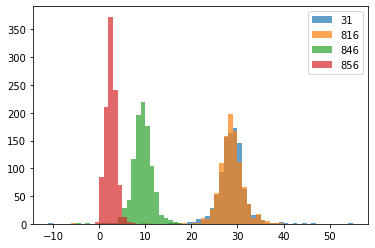

In [17]:
pm, mid = train_model(500,dropout = 0.1,id='sel')
t[mid],s[mid], e[mid] = eval_model(pm, test_ds)
p[mid] = pm

mae = raw_eval(t[mid],s[mid])

run_test(t[mid], s[mid], [31,816,846,856])

idx: 31 t: 31 p: 29
idx: 816 t: 44 p: 29
idx: 846 t: 14 p: 9
idx: 856 t: 4 p: 2


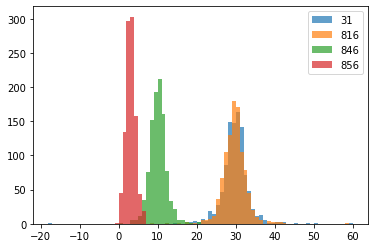

In [21]:
run_test(t[mid], s[mid], [31,816,846,856])

idx: 31 t: 31 p: 28
idx: 816 t: 44 p: 28
idx: 846 t: 14 p: 8
idx: 856 t: 4 p: 1


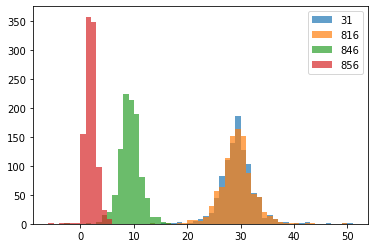

In [31]:
run_test(t[mid], s[mid], [31,816,846,856])

In [18]:
pitmodel = save_full_pitmodel(mid, 'sel', maxgap=65)

make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [03:45<00:00, 212.76it/s]


{
    "MSE": 2.170506532513962,
    "abs_error": 65189.56205482768,
    "abs_target_sum": 84410.26006088193,
    "abs_target_mean": 1.7620344444396605,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.307561021850031,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 42642.29159956571,
    "Coverage[0.1]": 0.7902515395052708,
    "QuantileLoss[0.5]": 65189.56205482768,
    "Coverage[0.5]": 0.9017847823817973,
    "QuantileLoss[0.9]": 24779.233726898732,
    "Coverage[0.9]": 0.9175242667779981,
    "RMSE": 1.4732639045717375,
    "NRMSE": 0.8361152696082771,
    "ND": 0.7722942922792668,
    "wQuantileLoss[0.1]": 0.5051790098598137,
    "wQuantileLoss[0.5]": 0.7722942922792668,
    "wQuantileLoss[0.9]": 0.2935571304842137,
    "mean_wQuantileLoss": 0.5236768108744314,
    "MAE_Coverage": 0.36985352955502204
}
save model pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle with 47905 keys.


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 167.80it/s, avg_epoch_loss=1.46]
INFO:root:Epoch[0] Elapsed time 0.598 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.459769
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 175.31it/s, avg_epoch_loss=1.16]
INFO:root:Epoch[1] Elapsed time 0.572 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=1.156980
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 177.78it/s, avg_epoch_loss=1.04]
INFO:root:Epoch[2] Elapsed time 0.564 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=1.044083
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 161.45it/s, avg_epoch_loss=0.999]
INFO:root:Epoch[3] Elapsed time 0.621 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.998903
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 174.63it/s,

INFO:root:Epoch[72] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 166.29it/s, avg_epoch_loss=0.886]
INFO:root:Epoch[72] Elapsed time 0.603 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=0.886178
INFO:root:Epoch[73] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 176.96it/s, avg_epoch_loss=0.859]
INFO:root:Epoch[73] Elapsed time 0.567 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.858979
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 180.35it/s, avg_epoch_loss=0.842]
INFO:root:Epoch[74] Elapsed time 0.556 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.841856
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 179.64it/s, avg_epoch_loss=0.848]
INFO:root:Epoch[75] Elapsed time 0.558 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.848252
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 160.43it/s,

100%|██████████| 100/100 [00:00<00:00, 182.21it/s, avg_epoch_loss=0.846]
INFO:root:Epoch[144] Elapsed time 0.550 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=0.846030
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.43it/s, avg_epoch_loss=0.829]
INFO:root:Epoch[145] Elapsed time 0.565 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.829087
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.57it/s, avg_epoch_loss=0.856]
INFO:root:Epoch[146] Elapsed time 0.558 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.856435
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.09it/s, avg_epoch_loss=0.89]
INFO:root:Epoch[147] Elapsed time 0.563 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.890187
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.51it/s, avg_epoch_loss=0.882]
INFO:root:Epoch[148] Ela

100%|██████████| 100/100 [00:00<00:00, 185.29it/s, avg_epoch_loss=0.845]
INFO:root:Epoch[216] Elapsed time 0.541 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=0.844898
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.51it/s, avg_epoch_loss=0.875]
INFO:root:Epoch[217] Elapsed time 0.552 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.874910
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.61it/s, avg_epoch_loss=0.881]
INFO:root:Epoch[218] Elapsed time 0.546 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.880921
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.62it/s, avg_epoch_loss=0.852]
INFO:root:Epoch[219] Elapsed time 0.591 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=0.852101
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 182.42it/s, avg_epoch_loss=0.884]
INFO:root:Epoch[220] El

100%|██████████| 100/100 [00:00<00:00, 181.26it/s, avg_epoch_loss=0.861]
INFO:root:Epoch[288] Elapsed time 0.553 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=0.860981
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.42it/s, avg_epoch_loss=0.89]
INFO:root:Epoch[289] Elapsed time 0.610 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.889782
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.86it/s, avg_epoch_loss=0.868]
INFO:root:Epoch[290] Elapsed time 0.612 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.867584
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.31it/s, avg_epoch_loss=0.862]
INFO:root:Epoch[291] Elapsed time 0.610 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.862231
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.29it/s, avg_epoch_loss=0.822]
INFO:root:Epoch[292] Ela

100%|██████████| 100/100 [00:00<00:00, 178.27it/s, avg_epoch_loss=0.847]
INFO:root:Epoch[360] Elapsed time 0.562 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=0.846922
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.71it/s, avg_epoch_loss=0.848]
INFO:root:Epoch[361] Elapsed time 0.558 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.848332
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.38it/s, avg_epoch_loss=0.839]
INFO:root:Epoch[362] Elapsed time 0.559 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.838736
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.22it/s, avg_epoch_loss=0.832]
INFO:root:Epoch[363] Elapsed time 0.559 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=0.831727
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.27it/s, avg_epoch_loss=0.833]
INFO:root:Epoch[364] El

100%|██████████| 100/100 [00:00<00:00, 161.93it/s, avg_epoch_loss=0.831]
INFO:root:Epoch[432] Elapsed time 0.619 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=0.830536
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.62it/s, avg_epoch_loss=0.825]
INFO:root:Epoch[433] Elapsed time 0.588 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=0.824616
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.71it/s, avg_epoch_loss=0.82]
INFO:root:Epoch[434] Elapsed time 0.558 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.819503
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.88it/s, avg_epoch_loss=0.865]
INFO:root:Epoch[435] Elapsed time 0.563 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.864777
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.26it/s, avg_epoch_loss=0.874]
INFO:root:Epoch[436] Ela

{
    "MSE": 1.039188971481898,
    "abs_error": 3980.5667862393107,
    "abs_target_sum": 5031.092032168558,
    "abs_target_mean": 1.0225796813350727,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.1213061459566063,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1520.6758291516526,
    "Coverage[0.1]": 0.10752032520325203,
    "QuantileLoss[0.5]": 3980.5667862393107,
    "Coverage[0.5]": 0.2733739837398374,
    "QuantileLoss[0.9]": 1921.0672762691524,
    "Coverage[0.9]": 0.6359756097560976,
    "RMSE": 1.0194061857188714,
    "NRMSE": 0.9968965786489538,
    "ND": 0.7911933951491565,
    "wQuantileLoss[0.1]": 0.30225561755351027,
    "wQuantileLoss[0.5]": 0.7911933951491565,
    "wQuantileLoss[0.9]": 0.38183902500410283,
    "mean_wQuantileLoss": 0.49176267923558986,
    "MAE_Coverage": 0.16605691056910568
}
mae =  7.400609756097561
idx: 31 t: 18 p: 23
idx: 816 t: 20 p: 10
idx: 846 t: 21 p: 16
idx: 856 t: 11 p: 8
make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [03:44<00:00, 213.06it/s]


{
    "MSE": 0.37917199785837763,
    "abs_error": 24063.23176426623,
    "abs_target_sum": 77647.07225634674,
    "abs_target_mean": 1.6208552814183643,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.39190953368788845,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 5534.42109281975,
    "Coverage[0.1]": 0.36827053543471455,
    "QuantileLoss[0.5]": 24063.23176426623,
    "Coverage[0.5]": 0.7598998016908465,
    "QuantileLoss[0.9]": 13768.186262890615,
    "Coverage[0.9]": 0.8316459659743242,
    "RMSE": 0.6157694356318586,
    "NRMSE": 0.3799040190022494,
    "ND": 0.3099052039569894,
    "wQuantileLoss[0.1]": 0.07127662295557287,
    "wQuantileLoss[0.5]": 0.3099052039569894,
    "wQuantileLoss[0.9]": 0.17731751967976134,
    "mean_wQuantileLoss": 0.18616644886410785,
    "MAE_Coverage": 0.1988414570504123
}
save model pitmodel-m65-mlp-dall-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle with 47905 keys.


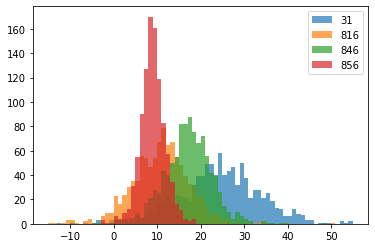

In [32]:
### run train on all data
trainset, testset, train_ds, test_ds, scaler = _data['all']

pm, mid = train_model(500,dropout = 0.1,id='all')
t[mid],s[mid], e[mid] = eval_model(pm, test_ds)
p[mid] = pm

mae = raw_eval(t[mid],s[mid])

run_test(t[mid], s[mid], [31,816,846,856])
pitmodel = save_full_pitmodel(mid, 'all', maxgap=65)

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 151.64it/s, avg_epoch_loss=1.47]
INFO:root:Epoch[0] Elapsed time 0.661 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.469403
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 157.18it/s, avg_epoch_loss=1.14]
INFO:root:Epoch[1] Elapsed time 0.638 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=1.137794
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 154.69it/s, avg_epoch_loss=0.915]
INFO:root:Epoch[2] Elapsed time 0.648 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.914556
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 169.43it/s, avg_epoch_loss=0.871]
INFO:root:Epoch[3] Elapsed time 0.592 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.870562
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 172.33it/s

INFO:root:Epoch[72] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 175.61it/s, avg_epoch_loss=0.718]
INFO:root:Epoch[72] Elapsed time 0.571 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=0.718308
INFO:root:Epoch[73] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 177.85it/s, avg_epoch_loss=0.681]
INFO:root:Epoch[73] Elapsed time 0.564 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.681050
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 179.53it/s, avg_epoch_loss=0.733]
INFO:root:Epoch[74] Elapsed time 0.558 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.732549
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 174.43it/s, avg_epoch_loss=0.738]
INFO:root:Epoch[75] Elapsed time 0.575 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.738408
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 178.53it/s,

100%|██████████| 100/100 [00:00<00:00, 181.94it/s, avg_epoch_loss=0.74]
INFO:root:Epoch[108] Elapsed time 0.551 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=0.740352
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.20it/s, avg_epoch_loss=0.705]
INFO:root:Epoch[109] Elapsed time 0.559 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.704802
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.39it/s, avg_epoch_loss=0.687]
INFO:root:Epoch[110] Elapsed time 0.553 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.686689
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.09it/s, avg_epoch_loss=0.712]
INFO:root:Epoch[111] Elapsed time 0.570 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.712036
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.99it/s, avg_epoch_loss=0.724]
INFO:root:Epoch[112] Ela

100%|██████████| 100/100 [00:00<00:00, 179.78it/s, avg_epoch_loss=0.728]
INFO:root:Epoch[180] Elapsed time 0.558 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=0.727965
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 184.58it/s, avg_epoch_loss=0.731]
INFO:root:Epoch[181] Elapsed time 0.544 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.730786
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.39it/s, avg_epoch_loss=0.735]
INFO:root:Epoch[182] Elapsed time 0.547 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=0.735243
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.64it/s, avg_epoch_loss=0.718]
INFO:root:Epoch[183] Elapsed time 0.610 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.718372
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.66it/s, avg_epoch_loss=0.692]
INFO:root:Epoch[184] El

100%|██████████| 100/100 [00:00<00:00, 179.66it/s, avg_epoch_loss=0.702]
INFO:root:Epoch[252] Elapsed time 0.558 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=0.702363
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 185.64it/s, avg_epoch_loss=0.705]
INFO:root:Epoch[253] Elapsed time 0.540 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=0.705442
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 182.54it/s, avg_epoch_loss=0.706]
INFO:root:Epoch[254] Elapsed time 0.549 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=0.705993
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.40it/s, avg_epoch_loss=0.718]
INFO:root:Epoch[255] Elapsed time 0.614 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=0.717514
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.91it/s, avg_epoch_loss=0.738]
INFO:root:Epoch[256] El

100%|██████████| 100/100 [00:00<00:00, 161.74it/s, avg_epoch_loss=0.68]
INFO:root:Epoch[324] Elapsed time 0.620 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=0.679599
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.95it/s, avg_epoch_loss=0.693]
INFO:root:Epoch[325] Elapsed time 0.583 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.692864
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.70it/s, avg_epoch_loss=0.701]
INFO:root:Epoch[326] Elapsed time 0.580 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.701017
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 184.78it/s, avg_epoch_loss=0.712]
INFO:root:Epoch[327] Elapsed time 0.542 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=0.711806
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.88it/s, avg_epoch_loss=0.705]
INFO:root:Epoch[328] Ela

100%|██████████| 100/100 [00:00<00:00, 179.21it/s, avg_epoch_loss=0.72]
INFO:root:Epoch[396] Elapsed time 0.559 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=0.719797
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.72it/s, avg_epoch_loss=0.718]
INFO:root:Epoch[397] Elapsed time 0.587 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=0.717534
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 151.13it/s, avg_epoch_loss=0.688]
INFO:root:Epoch[398] Elapsed time 0.663 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=0.688146
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.50it/s, avg_epoch_loss=0.682]
INFO:root:Epoch[399] Elapsed time 0.578 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=0.681879
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.05it/s, avg_epoch_loss=0.716]
INFO:root:Epoch[400] Ela

100%|██████████| 100/100 [00:00<00:00, 193.94it/s, avg_epoch_loss=0.719]
INFO:root:Epoch[468] Elapsed time 0.517 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=0.719060
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 191.86it/s, avg_epoch_loss=0.692]
INFO:root:Epoch[469] Elapsed time 0.523 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=0.692263
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 192.75it/s, avg_epoch_loss=0.707]
INFO:root:Epoch[470] Elapsed time 0.520 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=0.707448
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 191.76it/s, avg_epoch_loss=0.732]
INFO:root:Epoch[471] Elapsed time 0.523 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=0.731722
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 191.99it/s, avg_epoch_loss=0.679]
INFO:root:Epoch[472] El

{
    "MSE": 0.922615022583552,
    "abs_error": 3605.5270269594307,
    "abs_target_sum": 4883.632899466723,
    "abs_target_mean": 1.0253270836587702,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.0353874601944504,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1409.861401869293,
    "Coverage[0.1]": 0.13667856393029604,
    "QuantileLoss[0.5]": 3605.5270269594307,
    "Coverage[0.5]": 0.262019735460844,
    "QuantileLoss[0.9]": 1969.5693903192528,
    "Coverage[0.9]": 0.5903842116313248,
    "RMSE": 0.9605285121138009,
    "NRMSE": 0.9368020482656689,
    "ND": 0.7382878896063508,
    "wQuantileLoss[0.1]": 0.2886911098545604,
    "wQuantileLoss[0.5]": 0.7382878896063508,
    "wQuantileLoss[0.9]": 0.4033000495459688,
    "mean_wQuantileLoss": 0.4767596830022934,
    "MAE_Coverage": 0.19475820561270907
}
mae =  6.912240184757506
idx: 31 t: 18 p: 25
idx: 816 t: 2 p: 2
idx: 846 t: 35 p: 15
idx: 856 t: 25 p: 6
make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [03:44<00:00, 213.33it/s]


{
    "MSE": 2.072099756308953,
    "abs_error": 58884.045941364646,
    "abs_target_sum": 80870.58516372032,
    "abs_target_mean": 1.6881449778461604,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.5440069127184829,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 18850.915041648448,
    "Coverage[0.1]": 0.05383571652228369,
    "QuantileLoss[0.5]": 58884.045941364646,
    "Coverage[0.5]": 0.18883206345892914,
    "QuantileLoss[0.9]": 53647.7137817443,
    "Coverage[0.9]": 0.3778519987475211,
    "RMSE": 1.4394789877969574,
    "NRMSE": 0.8526986761726671,
    "ND": 0.7281268686526193,
    "wQuantileLoss[0.1]": 0.2330997729704228,
    "wQuantileLoss[0.5]": 0.7281268686526193,
    "wQuantileLoss[0.9]": 0.6633773413798844,
    "mean_wQuantileLoss": 0.5415346610009756,
    "MAE_Coverage": 0.2931600737570887
}
save model pitmodel-m65-mlp-dnoshort-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle with 47905 keys.


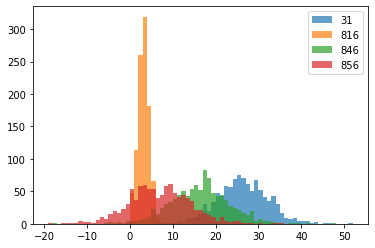

In [40]:
### run train on all data
tid = 'noshort'
trainset, testset, train_ds, test_ds, scaler = _data[tid]

pm, mid = train_model(500,dropout = 0.1,id=tid)
t[mid],s[mid], e[mid] = eval_model(pm, test_ds)
p[mid] = pm

mae = raw_eval(t[mid],s[mid])

run_test(t[mid], s[mid], [31,816,846,856])
pitmodel = save_full_pitmodel(mid, tid, maxgap=65)

In [ ]:
sys.exit(0)

### test and tuning

In [ ]:
s.keys()

In [ ]:
pm, mid = train_model(500,dropout = 0.1)
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
pm, mid = train_model(2000,dropout = 0.1)
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
save_model(p[mid], mid)
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
mid

In [ ]:
t.keys()

In [ ]:
pm, mid = train_model(200,dropout = 0.1, layers=[8,4])
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
e={}

In [ ]:
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
pm, mid = train_model(500, layers=[10,5])
t[mid],s[mid] = eval_model(pm)
p[mid] = pm

In [ ]:
pm, mid = train_model(500, layers=[32,16,8,4])
t[mid],s[mid] = eval_model(pm)
p[mid] = pm

In [ ]:
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
pm, mid = train_model(2000, layers=[32,16,8,4])
t[mid],s[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

### test

In [ ]:
trec = next(iter(train_ds))
trec


In [ ]:
run_test(tss, forecasts, [31,816,846,856])

In [ ]:
test_sel.iloc[816]

In [ ]:
test_sel.iloc[836]

In [ ]:
t[mid],s[mid] = eval_model(pm)

In [ ]:
get_pred(t[mid],s[mid], 816)

In [ ]:
next(iter(test_ds))

In [ ]:
scaler

In [ ]:
pm, mid = train_model(2,dropout = 0.1)
#t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
#run_test(t[mid], s[mid], [31,816,846,856])

#mid = 'mlp-e2000-l10-10-5-student-d0.1'
save_model(p[mid], mid)

### test pitmodel

In [ ]:
_scaler = scaler

In [ ]:
id = 'mlp-e2000-l10-10-5-student-d0.1'
t[id],s[id], e[id] = eval_model(p[id])

In [ ]:
forecasts = s[id]
tss = t[id]

scaler = _scaler
testset = test_sel[['lap2nextpit','caution_laps','pitage']].values

pitmodel = PitModel()

pitmodel.save_model('pitmodel_test', testset, forecasts, scaler)

In [ ]:
newcasts = pitmodel.forecast_ds(testset, forecasts)
scaler = _scaler
run_test(tss, newcasts, [31,816,846,856],raw_forecast=True)

In [ ]:
plt.plot(pitmodel.model['0-0'][0,:], pitmodel.model['0-0'][1,:])

In [ ]:
plt.plot(pitmodel.model['10-13'][0,:], pitmodel.model['10-13'][1,:])

In [ ]:
pitmodel.model['0-0'][0,:]

In [ ]:
scaler = _scaler
test_all = df_test[['lap2nextpit','caution_laps','pitage']].values
test_ds, _, test_set = makedb(test_all, scaler, perm=False)

id = 'mlp-e2000-l10-10-5-student-d0.1'
t[id],s[id], e[id] = eval_model(p[id])
forecasts = s[id]
tss = t[id]

pitmodel = PitModel()

pitmodel.save_model(f'mlp-{id}.pickle', test_all, forecasts, scaler)


In [ ]:
len(forecasts)

In [ ]:
testall_set

In [ ]:
scaler = _scaler
maxgap = 60
test_ds, _, test_set, test_all = make_fulltestdb(scaler, maxgap = maxgap)

id = 'mlp-e2000-l10-10-5-student-d0.1'

t[id],s[id], e[id] = eval_model(p[id])
forecasts = s[id]
tss = t[id]

pitmodel = PitModel()

pitmodel.save_model(f'pitmodel-m{maxgap}-{id}.pickle', test_all, forecasts, scaler)

In [ ]:
pitmodel.model['0-0'][0,:]

In [ ]:
plt.plot(pitmodel.model['0-0'][0,:], pitmodel.model['0-0'][1,:])

In [ ]:
t.keys()

In [ ]:
t['mlp-dsel-e500-l10-10-5-student-d0.1'][0]

### shortterm predictions using pitmodel(plen=2)

convert forecast samples of pitmodel to forecast samples of pit@plen laps

In [18]:
test_car12 = df_test[df_test['carno']==12]

In [19]:
test_ds, _, test_set = makedb(test_car12[['lap2nextpit','caution_laps','pitage']].values, scaler, perm=False)

In [20]:
len(test_set)

170

In [21]:
test

array([[ 1.88149958, -0.70945244, -1.40995345],
       [ 1.76852039, -0.70945244, -1.29736294],
       [ 1.6555412 , -0.70945244, -1.18477243],
       [ 1.54256201, -0.70945244, -1.07218192],
       [ 1.42958282, -0.70945244, -0.95959142],
       [ 1.31660363, -0.70945244, -0.84700091],
       [ 1.20362444, -0.70945244, -0.7344104 ],
       [ 1.09064525, -0.70945244, -0.62181989],
       [ 0.97766607, -0.70945244, -0.50922938],
       [ 0.86468688, -0.70945244, -0.39663887],
       [ 0.75170769, -0.70945244, -0.28404836],
       [ 0.6387285 , -0.70945244, -0.17145786],
       [ 0.52574931, -0.70945244, -0.05886735],
       [ 0.41277012, -0.70945244,  0.05372316],
       [ 0.29979093, -0.70945244,  0.16631367],
       [ 0.18681174, -0.70945244,  0.27890418],
       [ 0.07383255, -0.70945244,  0.39149469],
       [-0.03914664, -0.70945244,  0.5040852 ],
       [-0.15212582, -0.70945244,  0.6166757 ],
       [-0.26510501, -0.70945244,  0.72926621],
       [-0.3780842 , -0.70945244,  0.841

In [23]:
test_car12[test_car12['lap']==31]

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len
1059,18.0,0.0,0.0,1.0,12,5,31,18.0


In [24]:
test_car12[test_car12['lap']==30]

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len
1058,1.0,0.0,31.0,0.0,12,5,30,31.0


In [25]:
test_ds

[{'target': array([1.88149958]),
  'feat': array([-0.70945244, -1.40995345]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target': array([1.76852039]),
  'feat': array([-0.70945244, -1.29736294]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target': array([1.6555412]),
  'feat': array([-0.70945244, -1.18477243]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target': array([1.54256201]),
  'feat': array([-0.70945244, -1.07218192]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target': array([1.42958282]),
  'feat': array([-0.70945244, -0.95959142]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target':

In [26]:
len(test_ds)

170

In [28]:
test_set

array([[ 1.88149958, -0.70945244, -1.40995345],
       [ 1.76852039, -0.70945244, -1.29736294],
       [ 1.6555412 , -0.70945244, -1.18477243],
       [ 1.54256201, -0.70945244, -1.07218192],
       [ 1.42958282, -0.70945244, -0.95959142],
       [ 1.31660363, -0.70945244, -0.84700091],
       [ 1.20362444, -0.70945244, -0.7344104 ],
       [ 1.09064525, -0.70945244, -0.62181989],
       [ 0.97766607, -0.70945244, -0.50922938],
       [ 0.86468688, -0.70945244, -0.39663887],
       [ 0.75170769, -0.70945244, -0.28404836],
       [ 0.6387285 , -0.70945244, -0.17145786],
       [ 0.52574931, -0.70945244, -0.05886735],
       [ 0.41277012, -0.70945244,  0.05372316],
       [ 0.29979093, -0.70945244,  0.16631367],
       [ 0.18681174, -0.70945244,  0.27890418],
       [ 0.07383255, -0.70945244,  0.39149469],
       [-0.03914664, -0.70945244,  0.5040852 ],
       [-0.15212582, -0.70945244,  0.6166757 ],
       [-0.26510501, -0.70945244,  0.72926621],
       [-0.3780842 , -0.70945244,  0.841

### test

In [19]:
df12 = df_test[(df_test['eid']==5) & (df_test['carno']==12)]

In [20]:
df12[(df12['lap']>=45) & (df12['lap']<55)]

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len,cur_cautionlaps
1073,4.0,0.0,14.0,1.0,12,5,45,18.0,0.0
1074,3.0,0.0,15.0,1.0,12,5,46,18.0,0.0
1075,2.0,1.0,16.0,1.0,12,5,47,18.0,1.0
1076,1.0,2.0,17.0,1.0,12,5,48,18.0,2.0
1077,44.0,0.0,0.0,0.0,12,5,49,44.0,0.0
1078,43.0,1.0,1.0,0.0,12,5,50,44.0,1.0
1079,42.0,2.0,2.0,0.0,12,5,51,44.0,2.0
1080,41.0,3.0,3.0,0.0,12,5,52,44.0,3.0
1081,40.0,4.0,4.0,0.0,12,5,53,44.0,4.0
1082,39.0,4.0,5.0,0.0,12,5,54,44.0,0.0


In [21]:
df12

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len,cur_cautionlaps
1028,31.0,0.0,1.0,0.0,12,5,0,31.0,0.0
1029,30.0,0.0,2.0,0.0,12,5,1,31.0,0.0
1030,29.0,0.0,3.0,0.0,12,5,2,31.0,0.0
1031,28.0,0.0,4.0,0.0,12,5,3,31.0,0.0
1032,27.0,0.0,5.0,0.0,12,5,4,31.0,0.0
...,...,...,...,...,...,...,...,...,...
1193,5.0,20.0,37.0,0.0,12,5,165,42.0,0.0
1194,4.0,20.0,38.0,0.0,12,5,166,42.0,0.0
1195,3.0,20.0,39.0,0.0,12,5,167,42.0,0.0
1196,2.0,20.0,40.0,0.0,12,5,168,42.0,0.0


In [22]:
df12.cur_cautionlaps.values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1.,
       2., 3., 4., 0., 0., 0., 1., 2., 3., 4., 5., 0., 0., 0., 0., 0., 1.,
       2., 3., 4., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 2., 3., 4., 5., 6., 0., 1., 2., 3., 4., 5., 6., 7., 0.,
       1., 2., 3., 4., 5., 6., 7., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [23]:
train_set

array([[ 1.56895685, -0.64173227, -1.57348481, -0.21381922],
       [ 1.24715782, -0.64173227, -1.68074602, -0.21381922],
       [ 0.60355976, -0.64173227, -0.60813392, -0.21381922],
       ...,
       [ 0.06722804,  1.35544334,  0.35721696, -0.21381922],
       [-0.89816905,  0.35685554,  0.67900059, -0.21381922],
       [-0.68363636,  3.01975635,  1.53709027, -0.21381922]])

In [33]:
samples = np.zeros((1000))
for i in range(1000):
    samples[i] = pitmodel.predict(1,16,1)
    
samples[samples<5]

array([4., 4., 2., 2., 4., 4., 4., 3., 4., 1., 2., 4., 2., 3., 3., 2., 2.,
       3., 4., 4., 1., 3., 2., 2., 3., 4., 2., 4., 3., 4., 4., 1., 4., 3.,
       1., 4., 1., 1., 2., 1., 3., 1., 4., 2., 4., 3., 4., 2., 3., 4., 4.,
       2., 2., 1., 4., 2., 3., 3., 2., 2., 2., 4., 4., 4., 4., 1., 1., 3.,
       2., 2., 4., 4., 2., 1., 2., 1., 2., 3., 1., 3., 2., 2., 4., 2., 2.,
       1., 2., 4., 4., 2., 1., 4., 4., 2., 2., 1., 4., 4., 2., 3., 4., 4.,
       3., 3., 1., 3., 4., 4., 2., 2., 3., 4., 4., 3., 4.])

In [34]:
np.sum(samples<5)

115

In [35]:
np.min(samples)

1.0

In [36]:
np.max(samples)

39.0

In [34]:
test_all

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len,cur_cautionlaps
0,31.0,0.0,1.0,0.0,1,5,0,31.0,0.0
1,30.0,0.0,2.0,0.0,1,5,1,31.0,0.0
2,29.0,0.0,3.0,0.0,1,5,2,31.0,0.0
3,28.0,0.0,4.0,0.0,1,5,3,31.0,0.0
4,27.0,0.0,5.0,0.0,1,5,4,31.0,0.0
...,...,...,...,...,...,...,...,...,...
5566,999.0,5.0,26.0,0.0,98,5,195,0.0,0.0
5567,999.0,5.0,27.0,0.0,98,5,196,0.0,0.0
5568,999.0,5.0,28.0,0.0,98,5,197,0.0,0.0
5569,999.0,5.0,29.0,0.0,98,5,198,0.0,0.0


In [35]:
df_test

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len,cur_cautionlaps
0,31.0,0.0,1.0,0.0,1,5,0,31.0,0.0
1,30.0,0.0,2.0,0.0,1,5,1,31.0,0.0
2,29.0,0.0,3.0,0.0,1,5,2,31.0,0.0
3,28.0,0.0,4.0,0.0,1,5,3,31.0,0.0
4,27.0,0.0,5.0,0.0,1,5,4,31.0,0.0
...,...,...,...,...,...,...,...,...,...
5566,999.0,5.0,26.0,0.0,98,5,195,0.0,0.0
5567,999.0,5.0,27.0,0.0,98,5,196,0.0,0.0
5568,999.0,5.0,28.0,0.0,98,5,197,0.0,0.0
5569,999.0,5.0,29.0,0.0,98,5,198,0.0,0.0
